In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

In [2]:
# declarations
out_dir = "/ccb/salz8-1/avaraby/tx_noise/analysis_21042020/"
fig_dir = "/ccb/salz8-1/avaraby/tx_noise/analysis_21042020/figs/"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

readlen = 101

num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
# containers
no_sim_detected_real = [] # transcripts identified by each method not in real simulated data (real gff only)
no_sim_detected_splicing = []
no_sim_detected_intronic = []
no_sim_detected_intergenic = []
no_sim_detected_all = [] # transcripts identified by each method not in real simulated data (all gff only)

sim_undetected_no_real = []
sim_undetected_no_splicing = []
sim_undetected_no_intronic = []
sim_undetected_no_intergenic = []
sim_undetected_no_all = [] # transcripts identified by each method in real but not all

detected_fold_splicing = [] # fold change in expression for each method
detected_fold_intronic = []
detected_fold_intergenic = []
detected_fold_all = []

detected_r_real = []
detected_r_splicing = []
detected_r_intronic = []
detected_r_intergenic = []
detected_r_all = []

tpm_diff_real_slmn = []
tpm_diff_splicing_slmn = []
tpm_diff_intronic_slmn = []
tpm_diff_intergenic_slmn = []
tpm_diff_all_slmn = []

tpm_diff_real_klst = []
tpm_diff_splicing_klst = []
tpm_diff_intronic_klst = []
tpm_diff_intergenic_klst = []
tpm_diff_all_klst = []

In [4]:
tdf = pd.read_csv(out_dir+"real.t"+str(0)+"_s"+str(0)+".res")
tdf = tdf[tdf["sim_nreads"]>0].reset_index(drop=True)
tdf.head()

,tid,len,elen_true,elen_base,sim_nreads,sim_tpm,strg_elen,strg_nreads,strg_tpm,slmn_nreads,slmn_tpm,klst_nreads,klst_tpm
0,CHS.32633.20,15281,1794,1794,105,1.476621,1794,52.946503,0.720640,175.238998,1.729523,122.843002,1.564900
1,CHS.26921.24,3771,2036,405,255,3.159836,405,5.602356,0.337769,52.299000,5.112016,35.640701,2.521720
2,CHS.33306.1,879,879,682,149,4.276608,682,123.594048,4.425036,121.000000,4.261108,126.000000,4.671940
3,CHS.19368.5,22885,3653,3622,316,2.182426,3622,269.337616,1.815734,269.470001,1.218202,256.181000,1.569670
4,CHS.45696.6,14099,5524,5418,2823,12.893158,5418,6461.634277,29.121046,5366.414062,15.830794,6707.640137,27.218901


In [5]:
tdf = pd.read_csv(out_dir+"real.t"+str(0)+"_s"+str(0)+".res")
tdf = tdf[tdf["sim_nreads"]>0].reset_index(drop=True)
tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
               (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
               (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
print("Common between StringTie2 and Salmon: "+str(len(tdf_slmn)))

tdf_klst = tdf[(tdf["elen_base"]==tdf["strg_elen"])&\
               (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
               (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
print("Common between StringTie2 and Kallisto: "+str(len(tdf_klst)))

tdf_slkl = tdf[(tdf["slmn_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
               (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["slmn_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
print("Common between Kallisto and Salmon: "+str(len(tdf_slkl)))

Common between StringTie2 and Salmon: 758
Common between StringTie2 and Kallisto: 578
Common between Kallisto and Salmon: 1168


In [6]:
tdf[(tdf["slmn_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
               (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))].head()

,tid,len,elen_true,elen_base,sim_nreads,sim_tpm,strg_elen,strg_nreads,strg_tpm,slmn_nreads,slmn_tpm,klst_nreads,klst_tpm
18,CHS.36977.4,17780,3256,3256,441,3.417089,3256,439.901001,3.298938,441.0,2.236301,441.0,3.01544
42,CHS.46437.1,3464,3364,3364,312,2.339918,3364,311.990112,2.264584,312.0,1.527290,312.0,2.06279
64,CHS.58510.2,8864,858,858,120,3.528548,858,115.256592,3.280062,120.0,3.004616,120.0,3.41634
69,CHS.37584.3,18431,2303,2303,615,6.737260,2303,614.752441,6.517934,615.0,4.565620,615.0,6.02435
76,CHS.12241.3,3528,937,937,60,1.615525,937,60.000000,1.563562,60.0,1.329805,60.0,1.54695


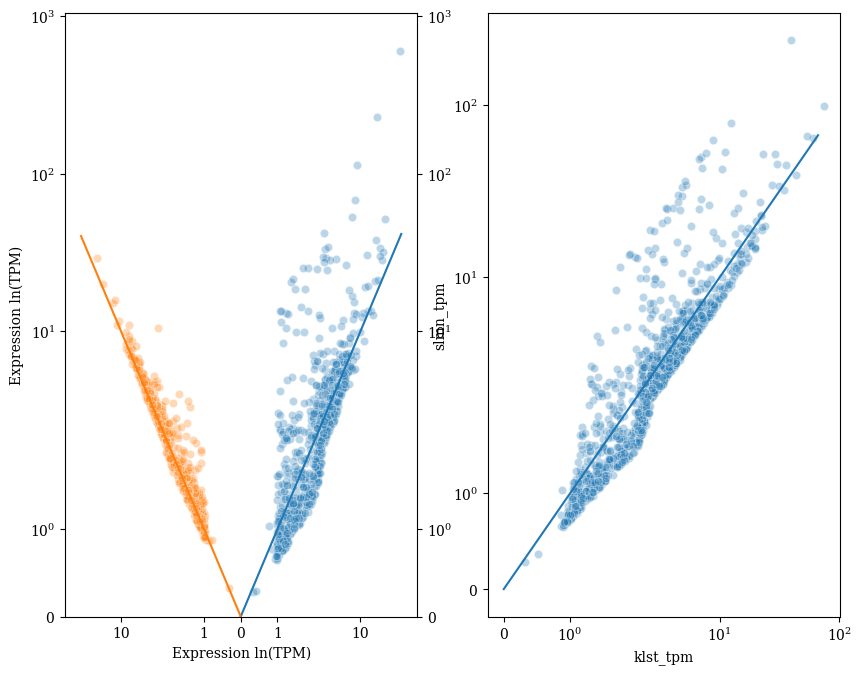

In [7]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,8),dpi=100)
sns.scatterplot(tdf_slmn["strg_tpm"],tdf_slmn["slmn_tpm"],alpha=0.3,ax=axes[0])
sns.lineplot([0,max(tdf_slmn["sim_tpm"])],[0,max(tdf_slmn["sim_tpm"])],ax=axes[0])

sns.scatterplot(0-tdf_klst["strg_tpm"],tdf_klst["klst_tpm"],alpha=0.3,ax=axes[0])
sns.lineplot([0,0-max(tdf_klst["sim_tpm"])],[0,max(tdf_klst["sim_tpm"])],ax=axes[0])

axes[0].set_yscale("symlog")
axes[0].set_xscale("symlog")
axes[0].set_ylim(0)
axes[0].tick_params(labelright=True,right=True)
axes[0].set_ylabel("Expression ln(TPM)")
axes[0].set_xlabel("Expression ln(TPM)")
ticks =  axes[0].get_xticks()
# set labels to absolute values and with integer representation
axes[0].set_xticklabels([int(abs(tick)) for tick in ticks])

sns.scatterplot(tdf_slkl["klst_tpm"],tdf_slkl["slmn_tpm"],alpha=0.3,ax=axes[1])
sns.lineplot([0,max(tdf_slkl["sim_tpm"])],[0,max(tdf_slkl["sim_tpm"])],ax=axes[1])
axes[1].set_yscale("symlog")
axes[1].set_xscale("symlog")

In [8]:
# violin plot of log fold changes
# null hypothesis is that there is no change in the expression of transcripts when noise is introduced
# compute fold change between experimental conditions (real vs real with different types of noise)
# for each tool - visualize as a series of violin plots
for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        print("\n=================\nTissue #"+str(tissue_num)+" - Sample #"+str(sample_num)+"\n=================\n")
        real_df = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        splicing_df = pd.read_csv(out_dir+"real_splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        intronic_df = pd.read_csv(out_dir+"real_intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        intergenic_df = pd.read_csv(out_dir+"real_intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        all_df = pd.read_csv(out_dir+"all.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        
        tdf = real_df[real_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_real_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_real_klst.append(tdf_klst)
        
        tdf = splicing_df[splicing_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_splicing_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_splicing_klst.append(tdf_klst)
        
        tdf = intronic_df[intronic_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_intronic_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_intronic_klst.append(tdf_klst)
        
        tdf = intergenic_df[intergenic_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_intergenic_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_intergenic_klst.append(tdf_klst)
        
        tdf = all_df[all_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_all_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_all_klst.append(tdf_klst)
        
        real_df["sim_cov"] = (readlen*real_df["sim_nreads"])/real_df["elen_true"]
        splicing_df["sim_cov"] = (readlen*splicing_df["sim_nreads"])/splicing_df["elen_true"]
        intronic_df["sim_cov"] = (readlen*intronic_df["sim_nreads"])/intronic_df["elen_true"]
        intergenic_df["sim_cov"] = (readlen*intergenic_df["sim_nreads"])/intergenic_df["elen_true"]
        all_df["sim_cov"] = (readlen*all_df["sim_nreads"])/all_df["elen_true"]
        
        # merge and compute fold_change in TPM
        merge_df = real_df[["tid","sim_nreads","sim_cov","sim_tpm","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]].merge(splicing_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        merge_df = merge_df.merge(intronic_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        merge_df = merge_df.merge(intergenic_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        merge_df = merge_df.merge(all_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        assert len(merge_df)==len(real_df),"lost transcripts during merge"
        merge_df.columns = ["tid",
                            "sim_nreads",
                            "sim_cov",
                            "sim_tpm",
                            "strg_tpm_real",
                            "strg_nreads_real",
                            "slmn_tpm_real",
                            "slmn_nreads_real",
                            "klst_tpm_real",
                            "klst_nreads_real",
                            "strg_tpm_splicing",
                            "strg_nreads_splicing",
                            "slmn_tpm_splicing",
                            "slmn_nreads_splicing",
                            "klst_tpm_splicing",
                            "klst_nreads_splicing",
                            "strg_tpm_intronic",
                            "strg_nreads_intronic",
                            "slmn_tpm_intronic",
                            "slmn_nreads_intronic",
                            "klst_tpm_intronic",
                            "klst_nreads_intronic",
                            "strg_tpm_intergenic",
                            "strg_nreads_intergenic",
                            "slmn_tpm_intergenic",
                            "slmn_nreads_intergenic",
                            "klst_tpm_intergenic",
                            "klst_nreads_intergenic",
                            "strg_tpm_all",
                            "strg_nreads_all",
                            "slmn_tpm_all",
                            "slmn_nreads_all",
                            "klst_tpm_all",
                            "klst_nreads_all"]
        
        # first how many transcripts are identified by each method that were not in the sample
        no_sim_detected_real.append(list())
        no_sim_detected_real[-1].append(merge_df[(merge_df["strg_tpm_real"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_real"]].reset_index(drop=True))
        no_sim_detected_real[-1].append(merge_df[(merge_df["slmn_tpm_real"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_real"]].reset_index(drop=True))
        no_sim_detected_real[-1].append(merge_df[(merge_df["klst_tpm_real"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_real"]].reset_index(drop=True))

        no_sim_detected_splicing.append(list())
        no_sim_detected_splicing[-1].append(merge_df[(merge_df["strg_tpm_splicing"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_splicing"]].reset_index(drop=True))
        no_sim_detected_splicing[-1].append(merge_df[(merge_df["slmn_tpm_splicing"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_splicing"]].reset_index(drop=True))
        no_sim_detected_splicing[-1].append(merge_df[(merge_df["klst_tpm_splicing"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_splicing"]].reset_index(drop=True))
        
        no_sim_detected_intronic.append(list())
        no_sim_detected_intronic[-1].append(merge_df[(merge_df["strg_tpm_intronic"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_intronic"]].reset_index(drop=True))
        no_sim_detected_intronic[-1].append(merge_df[(merge_df["slmn_tpm_intronic"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_intronic"]].reset_index(drop=True))
        no_sim_detected_intronic[-1].append(merge_df[(merge_df["klst_tpm_intronic"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_intronic"]].reset_index(drop=True))
        
        no_sim_detected_intergenic.append(list())
        no_sim_detected_intergenic[-1].append(merge_df[(merge_df["strg_tpm_intergenic"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_intergenic"]].reset_index(drop=True))
        no_sim_detected_intergenic[-1].append(merge_df[(merge_df["slmn_tpm_intergenic"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_intergenic"]].reset_index(drop=True))
        no_sim_detected_intergenic[-1].append(merge_df[(merge_df["klst_tpm_intergenic"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_intergenic"]].reset_index(drop=True))
        
        no_sim_detected_all.append(list())
        no_sim_detected_all[-1].append(merge_df[(merge_df["strg_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_all"]].reset_index(drop=True))
        no_sim_detected_all[-1].append(merge_df[(merge_df["slmn_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_all"]].reset_index(drop=True))
        no_sim_detected_all[-1].append(merge_df[(merge_df["klst_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_all"]].reset_index(drop=True))


        # next get information about those that were not identified at all (but were present in the real)
        sim_undetected_no_real.append(list())
        sim_undetected_no_real[-1].append(merge_df[(merge_df["strg_tpm_real"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_real","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_real[-1].append(merge_df[(merge_df["slmn_tpm_real"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_real","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_real[-1].append(merge_df[(merge_df["klst_tpm_real"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_real","sim_tpm","sim_cov"]].reset_index(drop=True))

        sim_undetected_no_splicing.append(list())
        sim_undetected_no_splicing[-1].append(merge_df[(merge_df["strg_tpm_splicing"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_splicing","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_splicing[-1].append(merge_df[(merge_df["slmn_tpm_splicing"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_splicing","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_splicing[-1].append(merge_df[(merge_df["klst_tpm_splicing"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_splicing","sim_tpm","sim_cov"]].reset_index(drop=True))

        sim_undetected_no_intronic.append(list())
        sim_undetected_no_intronic[-1].append(merge_df[(merge_df["strg_tpm_intronic"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_intronic","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_intronic[-1].append(merge_df[(merge_df["slmn_tpm_intronic"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_intronic","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_intronic[-1].append(merge_df[(merge_df["klst_tpm_intronic"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_intronic","sim_tpm","sim_cov"]].reset_index(drop=True))

        sim_undetected_no_intergenic.append(list())
        sim_undetected_no_intergenic[-1].append(merge_df[(merge_df["strg_tpm_intergenic"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_intergenic","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_intergenic[-1].append(merge_df[(merge_df["slmn_tpm_intergenic"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_intergenic","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_intergenic[-1].append(merge_df[(merge_df["klst_tpm_intergenic"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_intergenic","sim_tpm","sim_cov"]].reset_index(drop=True))

        sim_undetected_no_all.append(list())
        sim_undetected_no_all[-1].append(merge_df[(merge_df["strg_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_all","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_all[-1].append(merge_df[(merge_df["slmn_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_all","sim_tpm","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_all[-1].append(merge_df[(merge_df["klst_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_all","sim_tpm","sim_cov"]].reset_index(drop=True))


        # next get the fold change for everything that is left
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_splicing"]>0)][["tid","strg_tpm_real","strg_tpm_splicing"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_splicing"]>0)][["tid","slmn_tpm_real","slmn_tpm_splicing"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_splicing"]>0)][["tid","klst_tpm_real","klst_tpm_splicing"]].reset_index(drop=True)
        strg_df["strg_fold_splicing"] = ((strg_df["strg_tpm_splicing"]-strg_df["strg_tpm_real"])/strg_df["strg_tpm_real"])*100
        slmn_df["slmn_fold_splicing"] = ((slmn_df["slmn_tpm_splicing"]-slmn_df["slmn_tpm_real"])/slmn_df["slmn_tpm_real"])*100
        klst_df["klst_fold_splicing"] = ((klst_df["klst_tpm_splicing"]-klst_df["klst_tpm_real"])/klst_df["klst_tpm_real"])*100
        detected_fold_splicing.append(list())
        detected_fold_splicing[-1].append(strg_df[["tid","strg_fold_splicing"]])
        detected_fold_splicing[-1].append(slmn_df[["tid","slmn_fold_splicing"]])
        detected_fold_splicing[-1].append(klst_df[["tid","klst_fold_splicing"]])

        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_intronic"]>0)][["tid","strg_tpm_real","strg_tpm_intronic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_intronic"]>0)][["tid","slmn_tpm_real","slmn_tpm_intronic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_intronic"]>0)][["tid","klst_tpm_real","klst_tpm_intronic"]].reset_index(drop=True)
        strg_df["strg_fold_intronic"] = ((strg_df["strg_tpm_intronic"]-strg_df["strg_tpm_real"])/strg_df["strg_tpm_real"])*100
        slmn_df["slmn_fold_intronic"] = ((slmn_df["slmn_tpm_intronic"]-slmn_df["slmn_tpm_real"])/slmn_df["slmn_tpm_real"])*100
        klst_df["klst_fold_intronic"] = ((klst_df["klst_tpm_intronic"]-klst_df["klst_tpm_real"])/klst_df["klst_tpm_real"])*100
        detected_fold_intronic.append(list())
        detected_fold_intronic[-1].append(strg_df[["tid","strg_fold_intronic"]])
        detected_fold_intronic[-1].append(slmn_df[["tid","slmn_fold_intronic"]])
        detected_fold_intronic[-1].append(klst_df[["tid","klst_fold_intronic"]])

        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_intergenic"]>0)][["tid","strg_tpm_real","strg_tpm_intergenic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_intergenic"]>0)][["tid","slmn_tpm_real","slmn_tpm_intergenic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_intergenic"]>0)][["tid","klst_tpm_real","klst_tpm_intergenic"]].reset_index(drop=True)
        strg_df["strg_fold_intergenic"] = ((strg_df["strg_tpm_intergenic"]-strg_df["strg_tpm_real"])/strg_df["strg_tpm_real"])*100
        slmn_df["slmn_fold_intergenic"] = ((slmn_df["slmn_tpm_intergenic"]-slmn_df["slmn_tpm_real"])/slmn_df["slmn_tpm_real"])*100
        klst_df["klst_fold_intergenic"] = ((klst_df["klst_tpm_intergenic"]-klst_df["klst_tpm_real"])/klst_df["klst_tpm_real"])*100
        detected_fold_intergenic.append(list())
        detected_fold_intergenic[-1].append(strg_df[["tid","strg_fold_intergenic"]])
        detected_fold_intergenic[-1].append(slmn_df[["tid","slmn_fold_intergenic"]])
        detected_fold_intergenic[-1].append(klst_df[["tid","klst_fold_intergenic"]])

        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_all"]>0)][["tid","strg_tpm_real","strg_tpm_all"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_all"]>0)][["tid","slmn_tpm_real","slmn_tpm_all"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_all"]>0)][["tid","klst_tpm_real","klst_tpm_all"]].reset_index(drop=True)
        strg_df["strg_fold_all"] = ((strg_df["strg_tpm_all"]-strg_df["strg_tpm_real"])/strg_df["strg_tpm_real"])*100
        slmn_df["slmn_fold_all"] = ((slmn_df["slmn_tpm_all"]-slmn_df["slmn_tpm_real"])/slmn_df["slmn_tpm_real"])*100
        klst_df["klst_fold_all"] = ((klst_df["klst_tpm_all"]-klst_df["klst_tpm_real"])/klst_df["klst_tpm_real"])*100
        detected_fold_all.append(list())
        detected_fold_all[-1].append(strg_df[["tid","strg_fold_all"]])
        detected_fold_all[-1].append(slmn_df[["tid","slmn_fold_all"]])
        detected_fold_all[-1].append(klst_df[["tid","klst_fold_all"]])
        
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_real"]>0)][["tid","sim_nreads","strg_nreads_real"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_real"]>0)][["tid","sim_nreads","slmn_nreads_real"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_real"]>0)][["tid","sim_nreads","klst_nreads_real"]].reset_index(drop=True)
        detected_r_real.append(list())
        detected_r_real[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_real"]).rvalue)
        detected_r_real[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_real"]).rvalue)
        detected_r_real[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_real"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_splicing"]>0)][["tid","sim_nreads","strg_nreads_splicing"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_splicing"]>0)][["tid","sim_nreads","slmn_nreads_splicing"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_splicing"]>0)][["tid","sim_nreads","klst_nreads_splicing"]].reset_index(drop=True)
        detected_r_splicing.append(list())
        detected_r_splicing[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_splicing"]).rvalue)
        detected_r_splicing[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_splicing"]).rvalue)
        detected_r_splicing[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_splicing"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_intronic"]>0)][["tid","sim_nreads","strg_nreads_intronic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_intronic"]>0)][["tid","sim_nreads","slmn_nreads_intronic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_intronic"]>0)][["tid","sim_nreads","klst_nreads_intronic"]].reset_index(drop=True)
        detected_r_intronic.append(list())
        detected_r_intronic[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_intronic"]).rvalue)
        detected_r_intronic[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_intronic"]).rvalue)
        detected_r_intronic[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_intronic"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_intergenic"]>0)][["tid","sim_nreads","strg_nreads_intergenic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_intergenic"]>0)][["tid","sim_nreads","slmn_nreads_intergenic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_intergenic"]>0)][["tid","sim_nreads","klst_nreads_intergenic"]].reset_index(drop=True)
        detected_r_intergenic.append(list())
        detected_r_intergenic[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_intergenic"]).rvalue)
        detected_r_intergenic[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_intergenic"]).rvalue)
        detected_r_intergenic[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_intergenic"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_all"]>0)][["tid","sim_nreads","strg_nreads_all"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_all"]>0)][["tid","sim_nreads","slmn_nreads_all"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_all"]>0)][["tid","sim_nreads","klst_nreads_all"]].reset_index(drop=True)
        detected_r_all.append(list())
        detected_r_all[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_all"]).rvalue)
        detected_r_all[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_all"]).rvalue)
        detected_r_all[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_all"]).rvalue)


Tissue #0 - Sample #0


Tissue #0 - Sample #1


Tissue #0 - Sample #2


Tissue #0 - Sample #3


Tissue #0 - Sample #4


Tissue #0 - Sample #5


Tissue #0 - Sample #6


Tissue #0 - Sample #7


Tissue #0 - Sample #8


Tissue #0 - Sample #9


Tissue #1 - Sample #0


Tissue #1 - Sample #1


Tissue #1 - Sample #2


Tissue #1 - Sample #3


Tissue #1 - Sample #4


Tissue #1 - Sample #5


Tissue #1 - Sample #6


Tissue #1 - Sample #7


Tissue #1 - Sample #8


Tissue #1 - Sample #9


Tissue #2 - Sample #0


Tissue #2 - Sample #1


Tissue #2 - Sample #2


Tissue #2 - Sample #3


Tissue #2 - Sample #4


Tissue #2 - Sample #5


Tissue #2 - Sample #6


Tissue #2 - Sample #7


Tissue #2 - Sample #8


Tissue #2 - Sample #9



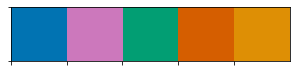

In [9]:
# get a custom colorblind pallete for full-size plots
# such that "all" color corresponds between full-size and small plots
custom_palette = sns.color_palette("colorblind",5)
tmp = custom_palette[4]
custom_palette[4] = custom_palette[1]
custom_palette[1] = tmp
sns.palplot(custom_palette)

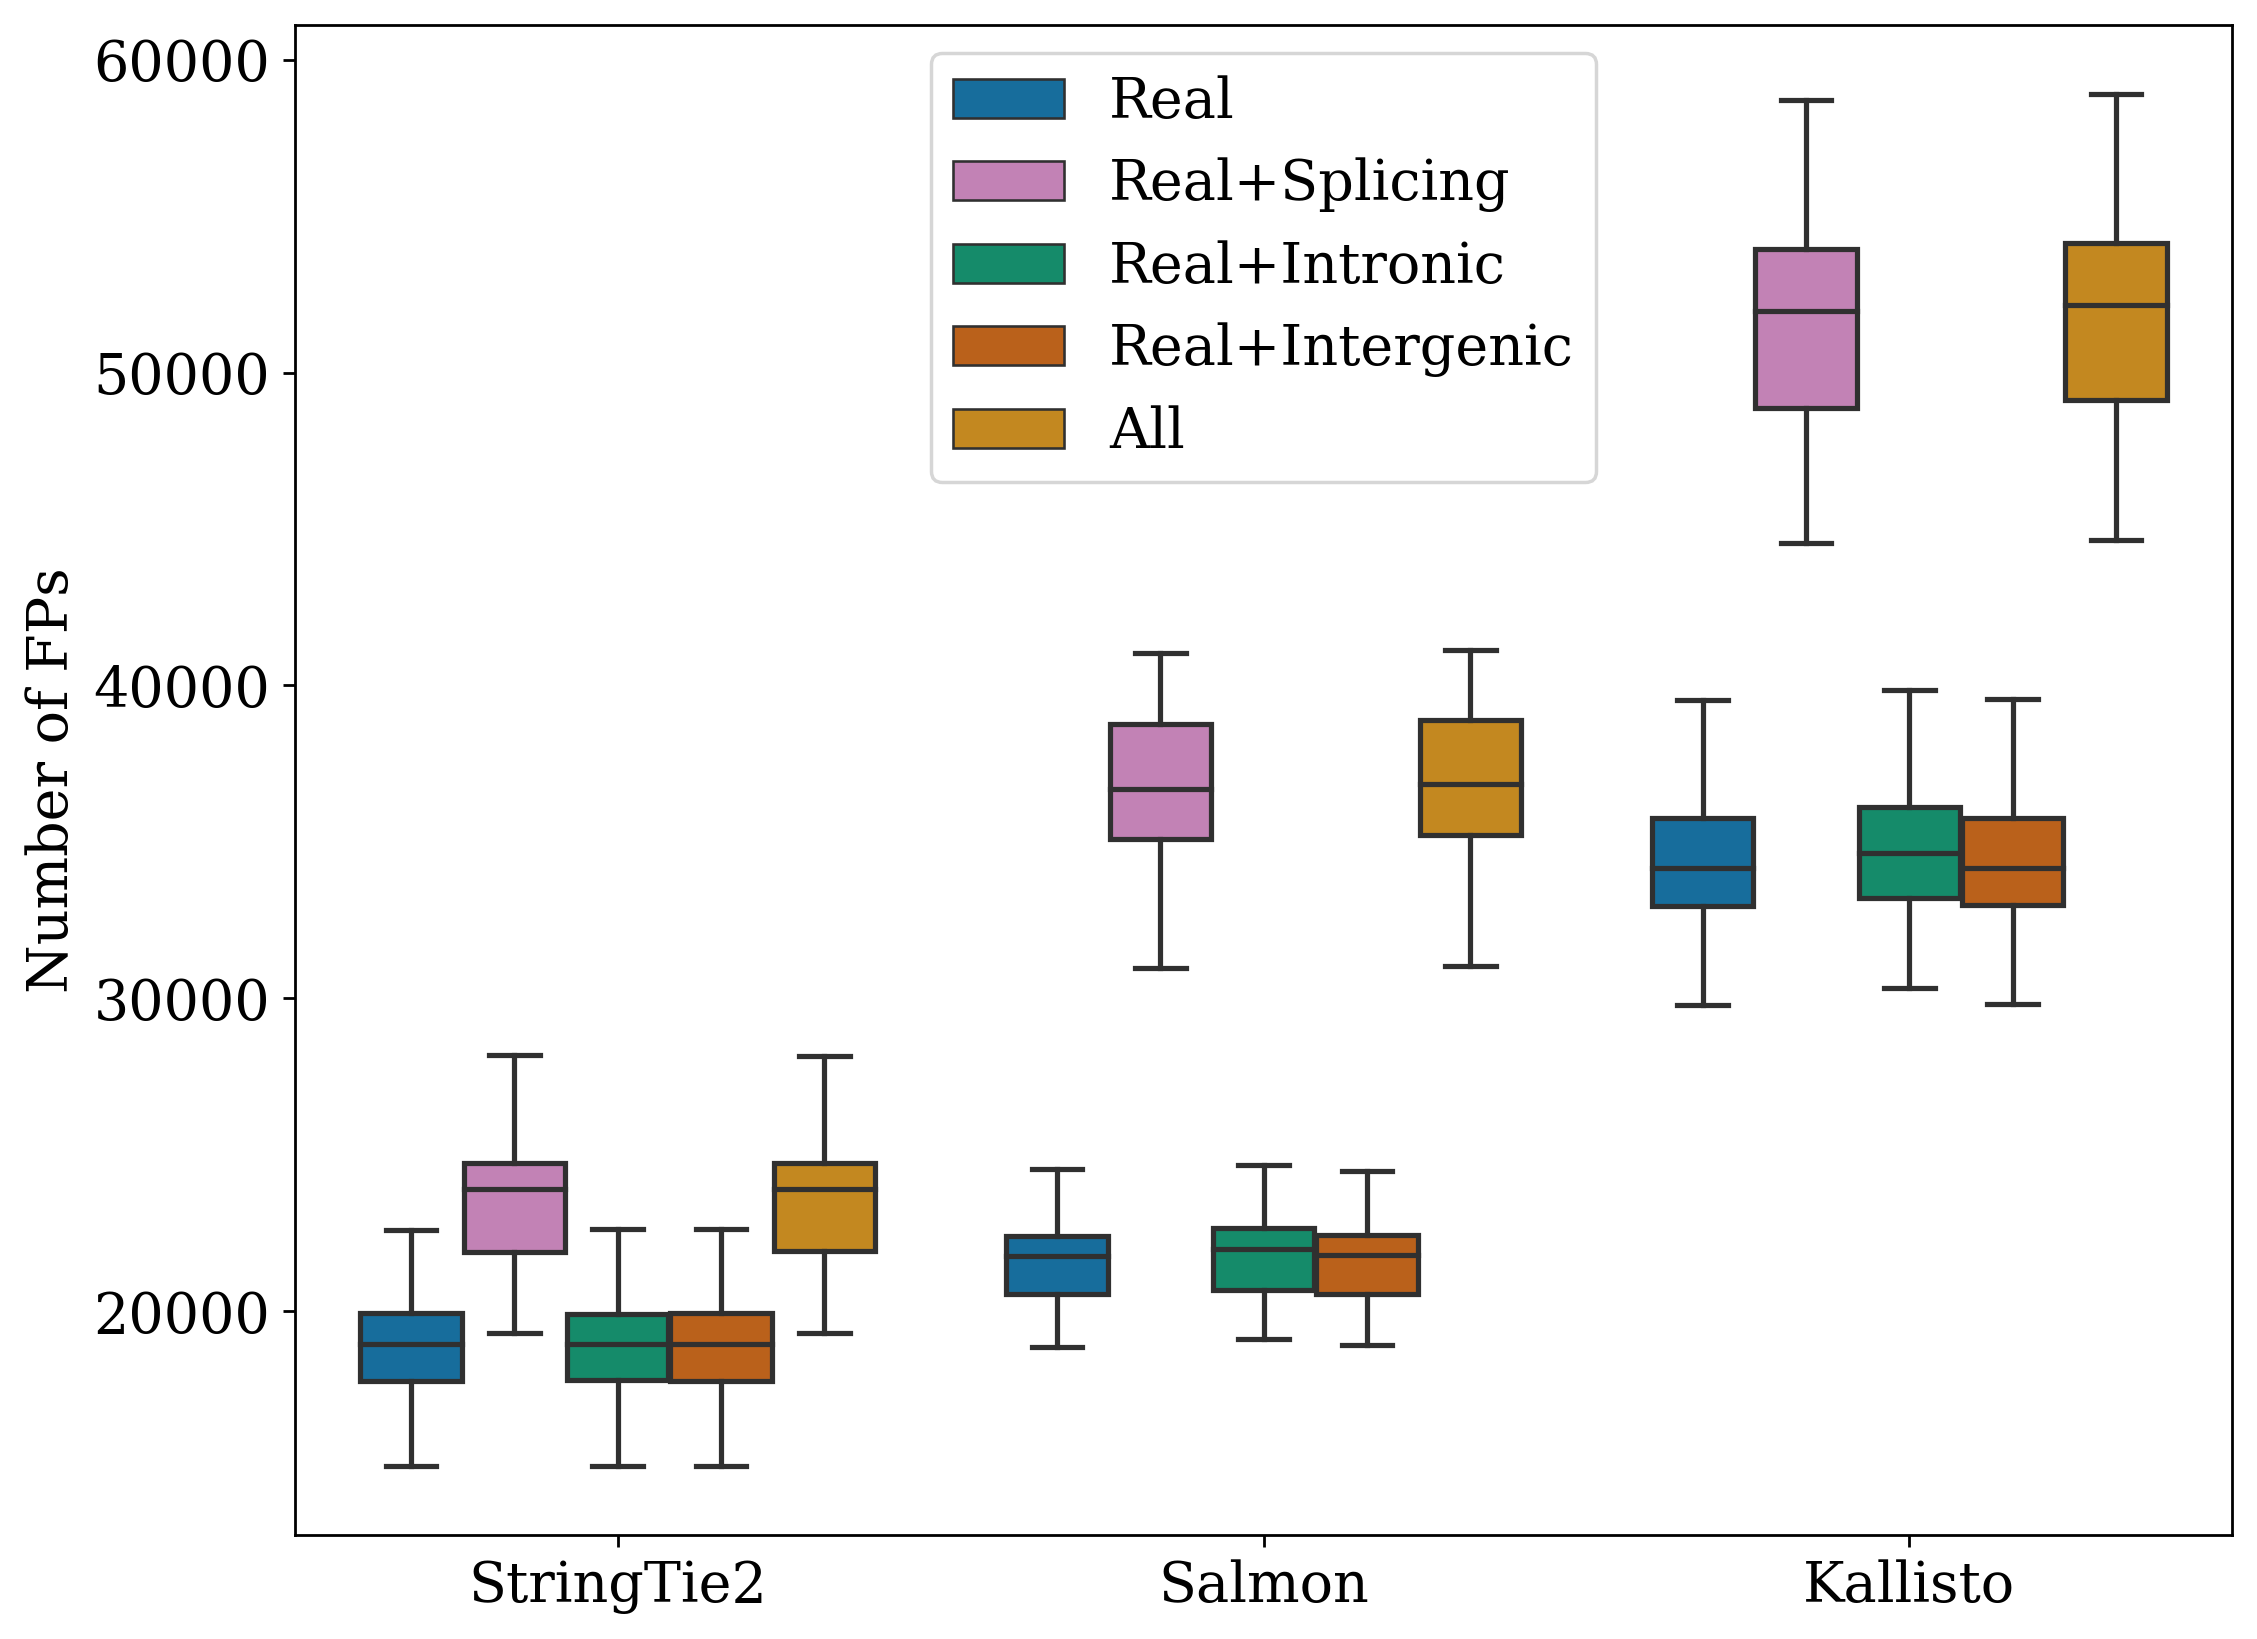

In [10]:
# plot number of transcripts in each group
num_txs_strg_real = []
num_txs_slmn_real = []
num_txs_klst_real = []

num_txs_strg_splicing = []
num_txs_slmn_splicing = []
num_txs_klst_splicing = []

num_txs_strg_intronic = []
num_txs_slmn_intronic = []
num_txs_klst_intronic = []

num_txs_strg_intergenic = []
num_txs_slmn_intergenic = []
num_txs_klst_intergenic = []

num_txs_strg_all = []
num_txs_slmn_all = []
num_txs_klst_all = []

for i in range(len(no_sim_detected_real)):
    num_txs_strg_real.append(len(no_sim_detected_real[i][0]))
    num_txs_slmn_real.append(len(no_sim_detected_real[i][1]))
    num_txs_klst_real.append(len(no_sim_detected_real[i][2]))
    
    num_txs_strg_splicing.append(len(no_sim_detected_splicing[i][0]))
    num_txs_slmn_splicing.append(len(no_sim_detected_splicing[i][1]))
    num_txs_klst_splicing.append(len(no_sim_detected_splicing[i][2]))
    
    num_txs_strg_intronic.append(len(no_sim_detected_intronic[i][0]))
    num_txs_slmn_intronic.append(len(no_sim_detected_intronic[i][1]))
    num_txs_klst_intronic.append(len(no_sim_detected_intronic[i][2]))
    
    num_txs_strg_intergenic.append(len(no_sim_detected_intergenic[i][0]))
    num_txs_slmn_intergenic.append(len(no_sim_detected_intergenic[i][1]))
    num_txs_klst_intergenic.append(len(no_sim_detected_intergenic[i][2]))
    
    num_txs_strg_all.append(len(no_sim_detected_all[i][0]))
    num_txs_slmn_all.append(len(no_sim_detected_all[i][1]))
    num_txs_klst_all.append(len(no_sim_detected_all[i][2]))
    
tmp = pd.DataFrame(num_txs_strg_real,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df = tmp.copy(deep=True)
tmp = pd.DataFrame(num_txs_strg_splicing,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intronic,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intergenic,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_all,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_slmn_real,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_splicing,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intronic,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intergenic,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_all,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_klst_real,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_splicing,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intronic,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intergenic,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_all,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

df.reset_index(drop=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.boxplot(x="method",y="num_txs",hue="type",data=df,palette=custom_palette)
# ax.set_title("Number of non-simulated transcripts (false positives) \n reported as expressed")
ax.set_xlabel("")
ax.set_ylabel("Number of FPs")
legend = plt.legend(loc="upper center")
fig.savefig(fig_dir+"tx_num_fp_all.png", format='png')
plt.show()

In [11]:
avg_strg_real = round(df[(df["method"]=="StringTie2")&(df["type"]=="Real")]["num_txs"].mean())
avg_slmn_real = round(df[(df["method"]=="Salmon")&(df["type"]=="Real")]["num_txs"].mean())
avg_klst_real = round(df[(df["method"]=="Kallisto")&(df["type"]=="Real")]["num_txs"].mean())

sd_strg_real = round(df[(df["method"]=="StringTie2")&(df["type"]=="Real")]["num_txs"].std())
sd_slmn_real = round(df[(df["method"]=="Salmon")&(df["type"]=="Real")]["num_txs"].std())
sd_klst_real = round(df[(df["method"]=="Kallisto")&(df["type"]=="Real")]["num_txs"].std())

for tp in set(df["type"]):
    if not tp=="Real":
        print("\n==== "+tp+" ====\n")
        avg_strg_tp = round(df[(df["method"]=="StringTie2")&(df["type"]==tp)]["num_txs"].mean())
        avg_slmn_tp = round(df[(df["method"]=="Salmon")&(df["type"]==tp)]["num_txs"].mean())
        avg_klst_tp = round(df[(df["method"]=="Kallisto")&(df["type"]==tp)]["num_txs"].mean())
        
        sd_strg_tp = round(df[(df["method"]=="StringTie2")&(df["type"]==tp)]["num_txs"].std())
        sd_slmn_tp = round(df[(df["method"]=="Salmon")&(df["type"]==tp)]["num_txs"].std())
        sd_klst_tp = round(df[(df["method"]=="Kallisto")&(df["type"]==tp)]["num_txs"].std())
        
        ch_strg = round(((avg_strg_tp-avg_strg_real)/avg_strg_real)*100,2)
        ch_slmn = round(((avg_slmn_tp-avg_slmn_real)/avg_slmn_real)*100,2)
        ch_klst = round(((avg_klst_tp-avg_klst_real)/avg_klst_real)*100,2)
        
        print("StringTie2: %change: "+str(ch_strg)+" : real: "+str(avg_strg_real)+" ; "+str(sd_strg_real)+" : new: "+str(avg_strg_tp)+" ; "+str(sd_strg_tp))
        print("Salmon: %change: "+str(ch_slmn)+" : real: "+str(avg_slmn_real)+" ; "+str(sd_slmn_real)+" : new: "+str(avg_slmn_tp)+" ; "+str(sd_slmn_tp))
        print("Kallisto: %change: "+str(ch_klst)+" : real: "+str(avg_klst_real)+" ; "+str(sd_klst_real)+" : new: "+str(avg_klst_tp)+" ; "+str(sd_klst_tp))


==== Real+Intronic ====

StringTie2: %change: 0.02 : real: 18844 ; 1922 : new: 18848 ; 1926
Salmon: %change: 0.85 : real: 21546 ; 1272 : new: 21729 ; 1277
Kallisto: %change: 1.04 : real: 34316 ; 2239 : new: 34673 ; 2252

==== Real+Splicing ====

StringTie2: %change: 24.66 : real: 18844 ; 1922 : new: 23490 ; 2504
Salmon: %change: 69.76 : real: 21546 ; 1272 : new: 36576 ; 2693
Kallisto: %change: 49.43 : real: 34316 ; 2239 : new: 51280 ; 3561

==== Real+Intergenic ====

StringTie2: %change: -0.03 : real: 18844 ; 1922 : new: 18839 ; 1917
Salmon: %change: 0.01 : real: 21546 ; 1272 : new: 21549 ; 1268
Kallisto: %change: 0.06 : real: 34316 ; 2239 : new: 34337 ; 2236

==== All ====

StringTie2: %change: 24.68 : real: 18844 ; 1922 : new: 23494 ; 2510
Salmon: %change: 70.23 : real: 21546 ; 1272 : new: 36677 ; 2705
Kallisto: %change: 50.01 : real: 34316 ; 2239 : new: 51478 ; 3585


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


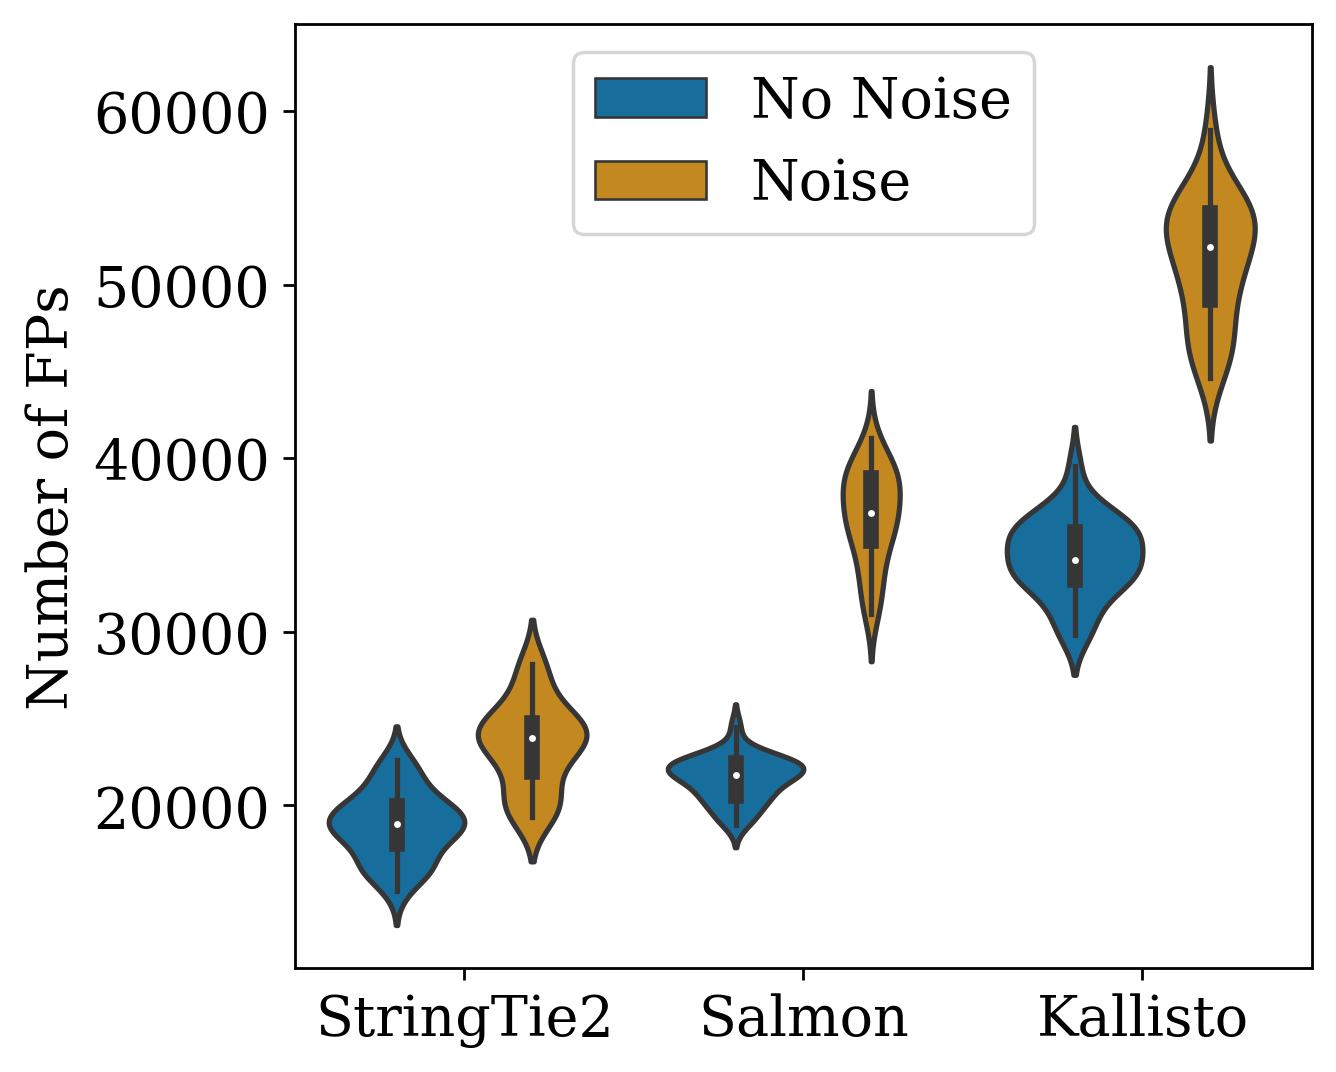

In [12]:
sub_df = df[df["type"].isin(["Real","All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","No Noise","Noise")
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(5.25,5),dpi=250)
ax = sns.violinplot(x="method",y="num_txs",hue="type",data=sub_df,palette="colorblind")
# ax.set_title("False Positive Rate in the Absence and \n Presence of Noisy Transcription")
ax.set_xlabel("")
ax.set_ylabel("Number of FPs")
legend = plt.legend(loc='upper center')
fig.savefig(fig_dir+"tx_num_fp_small.eps", format='eps')
plt.show()

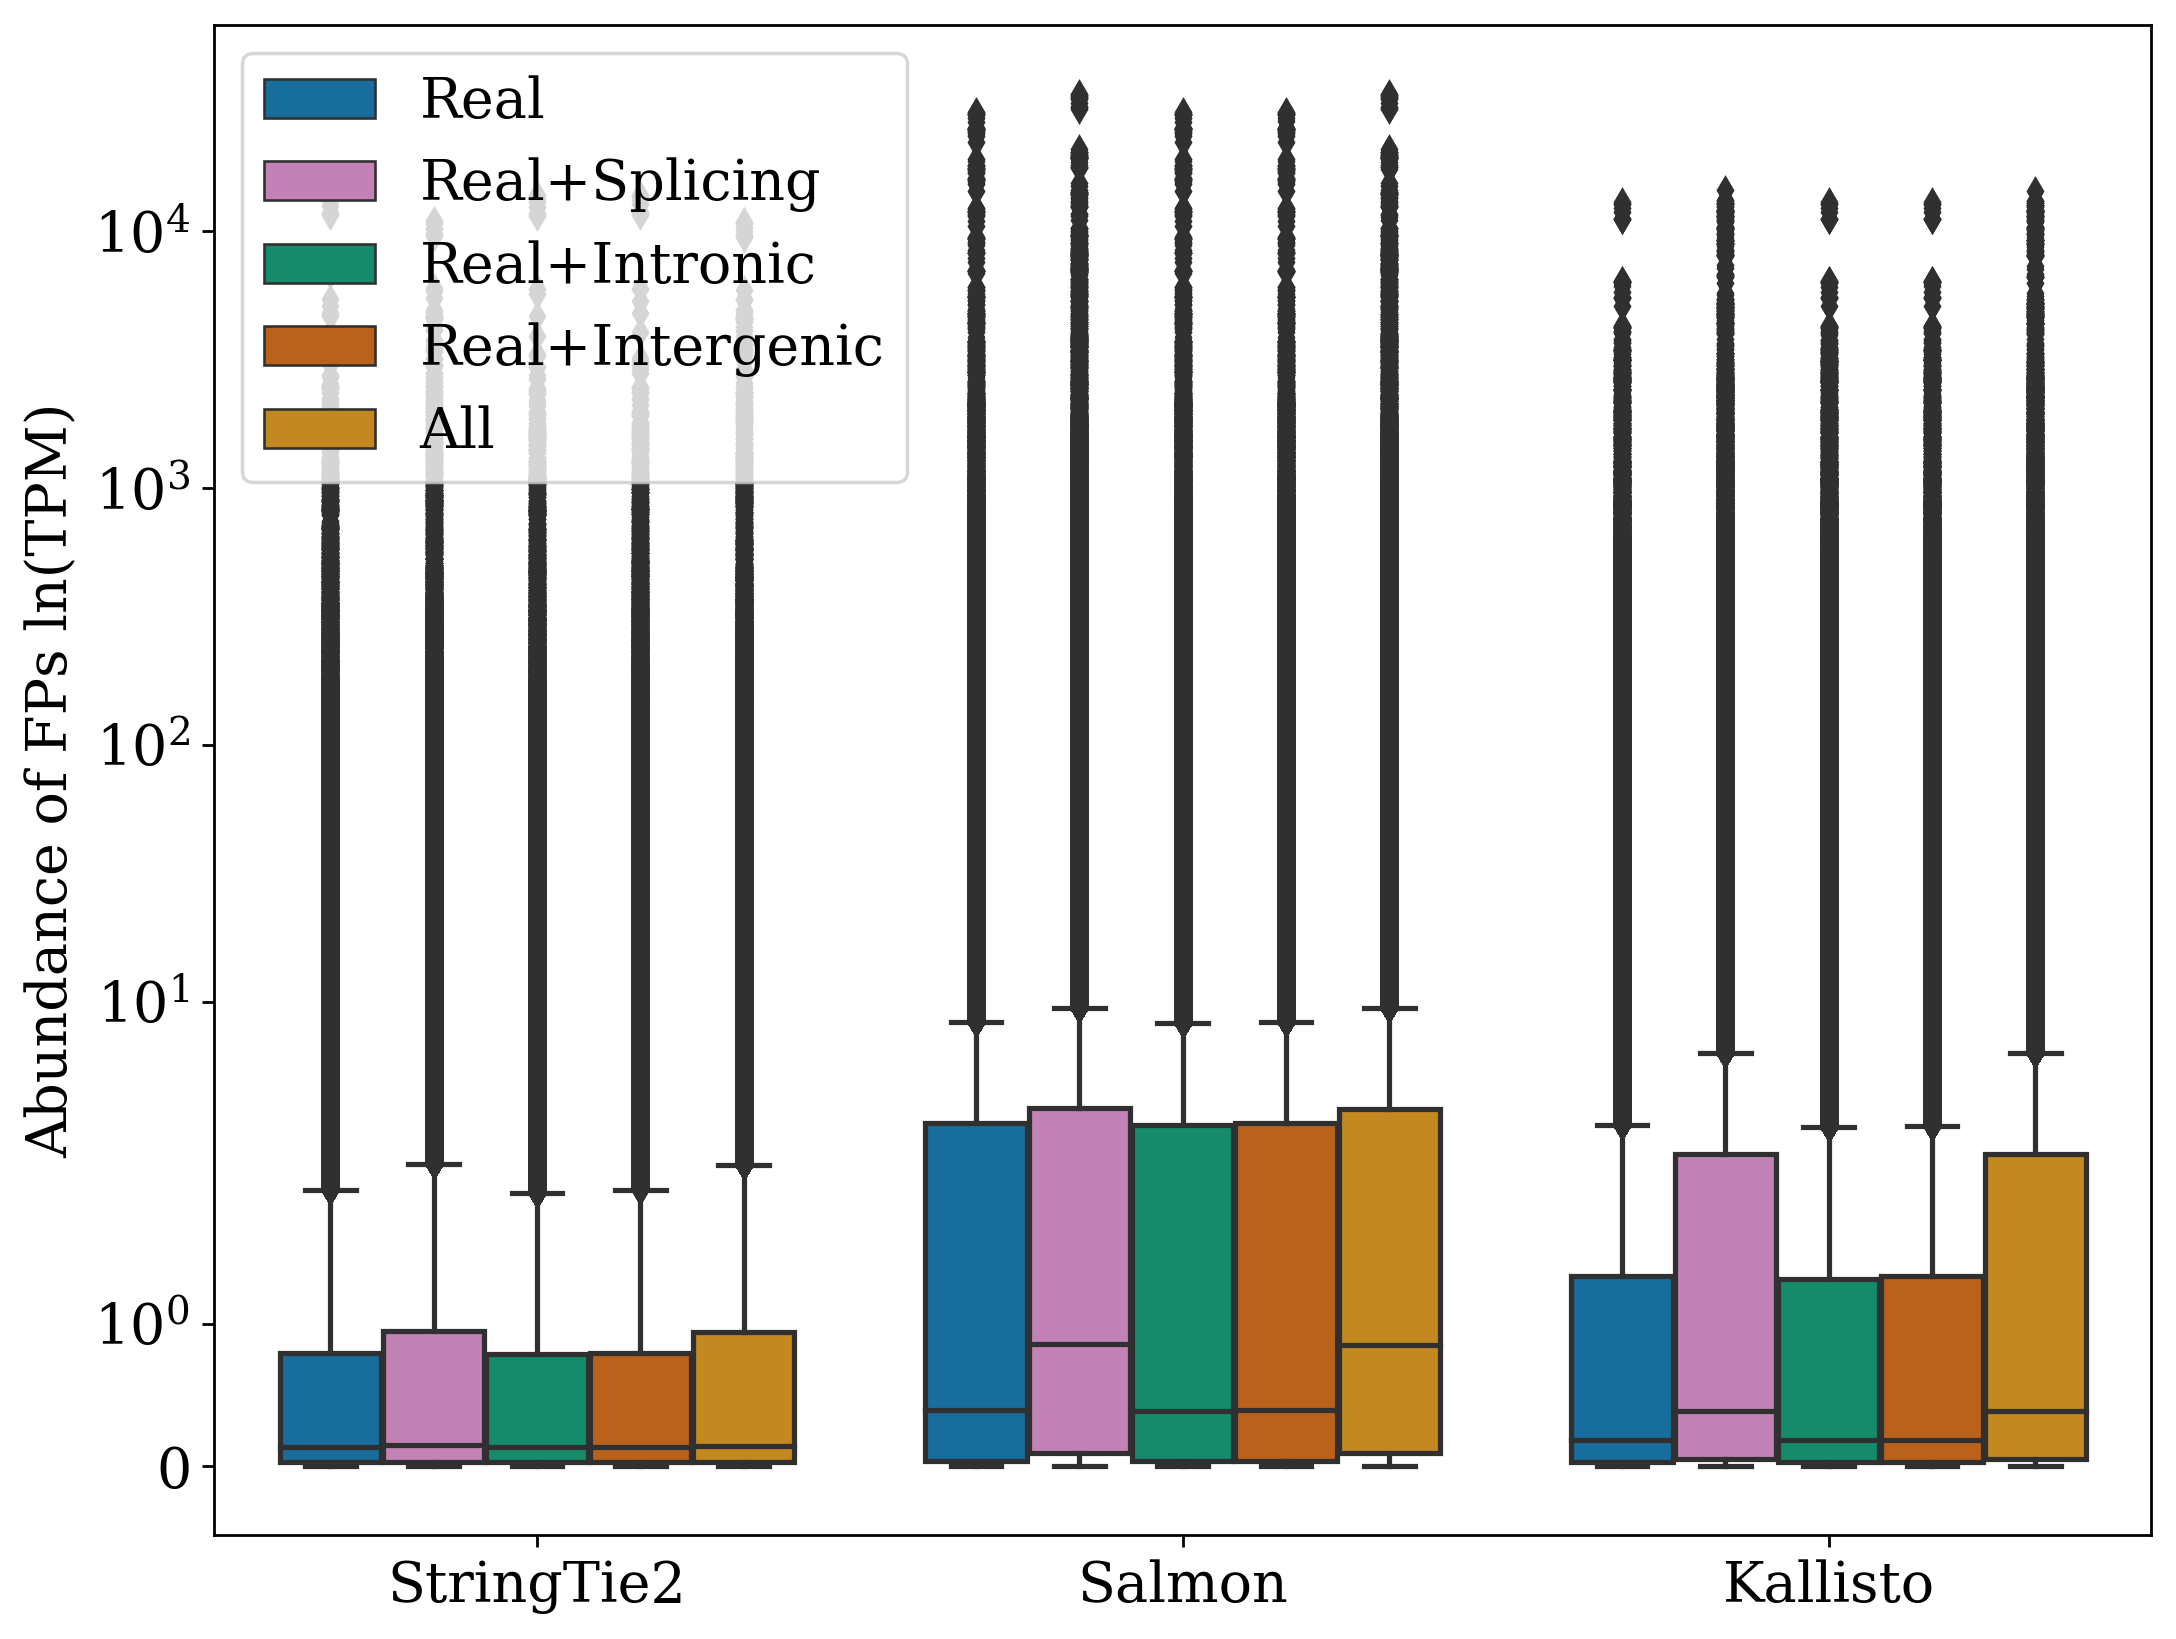

In [13]:
# plot expression values in each group
tpm_strg_real = []
tpm_slmn_real = []
tpm_klst_real = []

tpm_strg_splicing = []
tpm_slmn_splicing = []
tpm_klst_splicing = []

tpm_strg_intronic = []
tpm_slmn_intronic = []
tpm_klst_intronic = []

tpm_strg_intergenic = []
tpm_slmn_intergenic = []
tpm_klst_intergenic = []

tpm_strg_all = []
tpm_slmn_all = []
tpm_klst_all = []

for i in range(len(no_sim_detected_real)):
    tpm_strg_real.extend(no_sim_detected_real[i][0]["strg_tpm_real"].tolist())
    tpm_slmn_real.extend(no_sim_detected_real[i][1]["slmn_tpm_real"].tolist())
    tpm_klst_real.extend(no_sim_detected_real[i][2]["klst_tpm_real"].tolist())
    
    tpm_strg_splicing.extend(no_sim_detected_splicing[i][0]["strg_tpm_splicing"].tolist())
    tpm_slmn_splicing.extend(no_sim_detected_splicing[i][1]["slmn_tpm_splicing"].tolist())
    tpm_klst_splicing.extend(no_sim_detected_splicing[i][2]["klst_tpm_splicing"].tolist())
    
    tpm_strg_intronic.extend(no_sim_detected_intronic[i][0]["strg_tpm_intronic"].tolist())
    tpm_slmn_intronic.extend(no_sim_detected_intronic[i][1]["slmn_tpm_intronic"].tolist())
    tpm_klst_intronic.extend(no_sim_detected_intronic[i][2]["klst_tpm_intronic"].tolist())
    
    tpm_strg_intergenic.extend(no_sim_detected_intergenic[i][0]["strg_tpm_intergenic"].tolist())
    tpm_slmn_intergenic.extend(no_sim_detected_intergenic[i][1]["slmn_tpm_intergenic"].tolist())
    tpm_klst_intergenic.extend(no_sim_detected_intergenic[i][2]["klst_tpm_intergenic"].tolist())
    
    tpm_strg_all.extend(no_sim_detected_all[i][0]["strg_tpm_all"].tolist())
    tpm_slmn_all.extend(no_sim_detected_all[i][1]["slmn_tpm_all"].tolist())
    tpm_klst_all.extend(no_sim_detected_all[i][2]["klst_tpm_all"].tolist())
    
tmp = pd.DataFrame(tpm_strg_real,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df_tpm = tmp.copy(deep=True)
tmp = pd.DataFrame(tpm_strg_splicing,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_strg_intronic,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_strg_intergenic,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_strg_all,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df_tpm = pd.concat([df_tpm,tmp],axis=0)

tmp = pd.DataFrame(tpm_slmn_real,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_splicing,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_intronic,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_intergenic,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_all,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df_tpm = pd.concat([df_tpm,tmp],axis=0)

tmp = pd.DataFrame(tpm_klst_real,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_splicing,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_intronic,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_intergenic,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_all,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df_tpm = pd.concat([df_tpm,tmp],axis=0)

df_tpm.reset_index(drop=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.boxplot(x="method",y="tpm",hue="type",data=df_tpm,palette=custom_palette)
ax.set_yscale("symlog")
# ax.set_title("Expression values of non-simulated transcripts identified as simulated")
ax.set_xlabel("")
ax.set_ylabel("Abundance of FPs ln(TPM)")
legend = plt.legend(loc="upper left")
fig.savefig(fig_dir+"tx_exp_fp_all_outliers.png", format='png')
plt.show()

In [14]:
avg_strg_real = df_tpm[(df_tpm["method"]=="StringTie2")&(df_tpm["type"]=="Real")]["tpm"].median()
avg_slmn_real = df_tpm[(df_tpm["method"]=="Salmon")&(df_tpm["type"]=="Real")]["tpm"].median()
avg_klst_real = df_tpm[(df_tpm["method"]=="Kallisto")&(df_tpm["type"]=="Real")]["tpm"].median()

for tp in set(df_tpm["type"]):
    if not tp=="Real":
        print("\n==== "+tp+" ====\n")
        avg_strg_tp = df_tpm[(df_tpm["method"]=="StringTie2")&(df_tpm["type"]==tp)]["tpm"].median()
        avg_slmn_tp = df_tpm[(df_tpm["method"]=="Salmon")&(df_tpm["type"]==tp)]["tpm"].median()
        avg_klst_tp = df_tpm[(df_tpm["method"]=="Kallisto")&(df_tpm["type"]==tp)]["tpm"].median()
        
        ch_strg = round(((avg_strg_tp-avg_strg_real)/avg_strg_real)*100,2)
        ch_slmn = round(((avg_slmn_tp-avg_slmn_real)/avg_slmn_real)*100,2)
        ch_klst = round(((avg_klst_tp-avg_klst_real)/avg_klst_real)*100,2)
        
        print("StringTie2: %change: "+str(ch_strg)+" : real: "+str(round(avg_strg_real,2))+" : new: "+str(round(avg_strg_tp,2)))
        print("Salmon: %change: "+str(ch_slmn)+" : real: "+str(round(avg_slmn_real,2))+" : new: "+str(round(avg_slmn_tp,2)))
        print("Kallisto: %change: "+str(ch_klst)+" : real: "+str(round(avg_klst_real,2))+" : new: "+str(round(avg_klst_tp,2)))


==== Real+Intronic ====

StringTie2: %change: -0.98 : real: 0.14 : new: 0.13
Salmon: %change: -2.16 : real: 0.4 : new: 0.39
Kallisto: %change: -1.21 : real: 0.19 : new: 0.19

==== Real+Splicing ====

StringTie2: %change: 8.98 : real: 0.14 : new: 0.15
Salmon: %change: 116.24 : real: 0.4 : new: 0.86
Kallisto: %change: 108.17 : real: 0.19 : new: 0.39

==== Real+Intergenic ====

StringTie2: %change: 0.19 : real: 0.14 : new: 0.14
Salmon: %change: -0.14 : real: 0.4 : new: 0.4
Kallisto: %change: -0.13 : real: 0.19 : new: 0.19

==== All ====

StringTie2: %change: 7.77 : real: 0.14 : new: 0.15
Salmon: %change: 115.28 : real: 0.4 : new: 0.85
Kallisto: %change: 106.46 : real: 0.19 : new: 0.39


In [15]:
for tp in set(df_tpm["type"]):
    print("\n==== "+tp+" ====\n")
    strg_tp = len(df_tpm[(df_tpm["method"]=="StringTie2")&(df_tpm["type"]==tp)&(df_tpm["tpm"]>1)]["tpm"])
    slmn_tp = len(df_tpm[(df_tpm["method"]=="Salmon")&(df_tpm["type"]==tp)&(df_tpm["tpm"]>1)]["tpm"])
    klst_tp = len(df_tpm[(df_tpm["method"]=="Kallisto")&(df_tpm["type"]==tp)&(df_tpm["tpm"]>1)]["tpm"])

    print("StringTie2: number FP >1TPM: "+str(strg_tp))
    print("Salmon: number FP >1TPM: "+str(slmn_tp))
    print("Kallisto: number FP >1TPM: "+str(klst_tp))


==== Real+Intronic ====

StringTie2: number FP >1TPM: 126044
Salmon: number FP >1TPM: 262750
Kallisto: number FP >1TPM: 291544

==== Real+Splicing ====

StringTie2: number FP >1TPM: 172027
Salmon: number FP >1TPM: 523903
Kallisto: number FP >1TPM: 587652

==== Real+Intergenic ====

StringTie2: number FP >1TPM: 126902
Salmon: number FP >1TPM: 261973
Kallisto: number FP >1TPM: 290579

==== Real ====

StringTie2: number FP >1TPM: 126735
Salmon: number FP >1TPM: 262085
Kallisto: number FP >1TPM: 290537

==== All ====

StringTie2: number FP >1TPM: 171087
Salmon: number FP >1TPM: 524694
Kallisto: number FP >1TPM: 588177


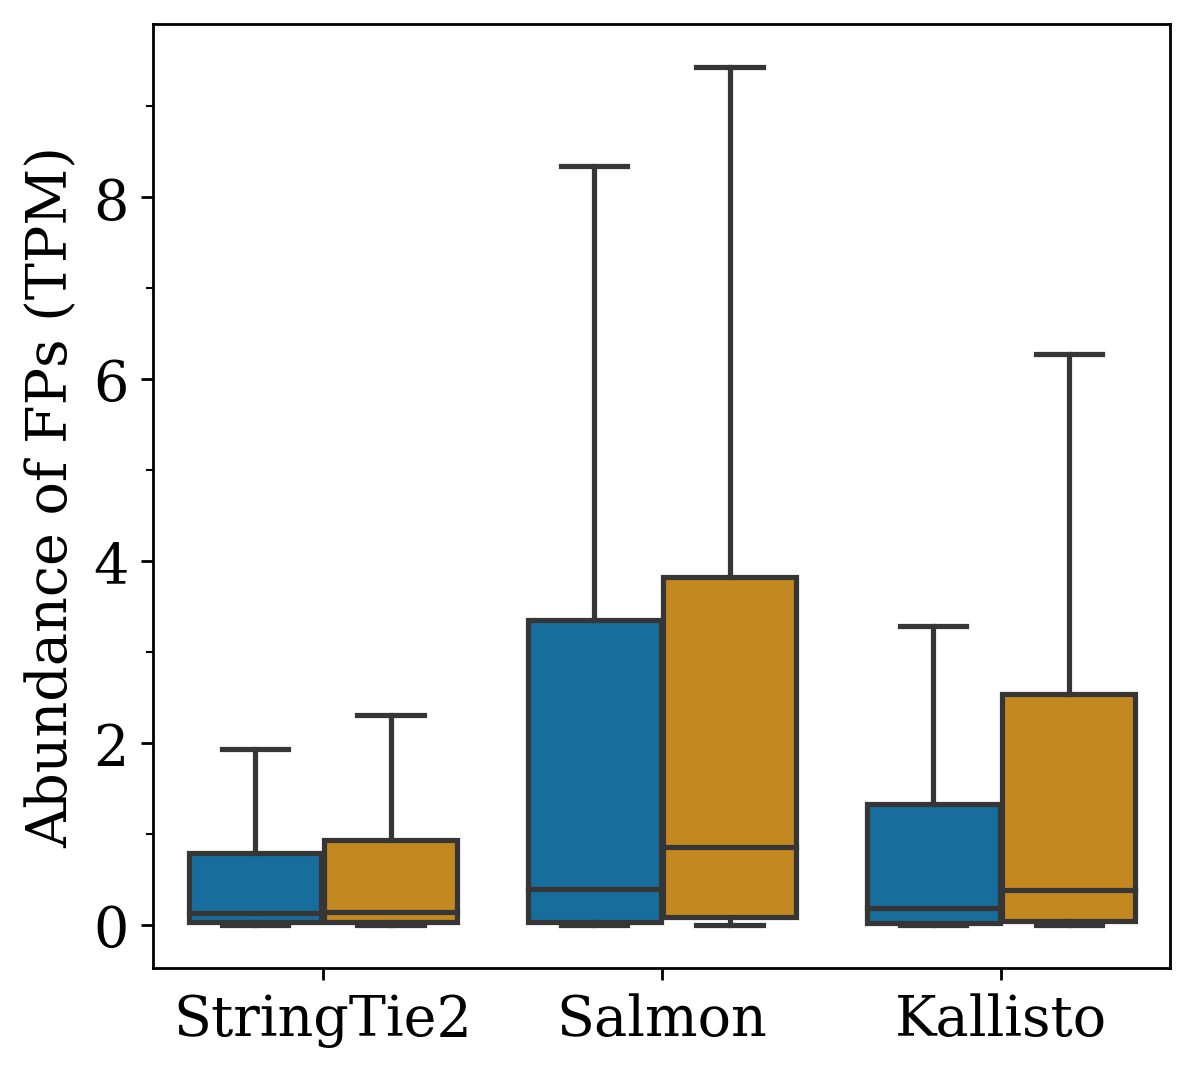

In [16]:
sub_df = df_tpm[df_tpm["type"].isin(["Real","All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(5.25,5),dpi=250)
ax = sns.boxplot(x="method",y="tpm",hue="type",data=sub_df,palette="colorblind",showfliers=False)
# ax.set_yscale("symlog")
# ax.set_title("Estimated Expression of False Positives \n in the Absence and Presence of Noise")
# ax.set_xlabel("Method")
ax.set_ylabel("Abundance of FPs (TPM)")
legend = ax.legend()
# plt.legend(loc='upper left')
ax.legend().remove()
ax.set_xlabel("")
# ticks =  ax.get_yticks()
# print(max(ticks))
# ax.set_yticks(list(range(0,int(max(ticks)),1)))
ax.yaxis.set_minor_locator(MultipleLocator(1))
fig.savefig(fig_dir+"tx_exp_fp_small_no_outliers.eps", format='eps')
plt.show()

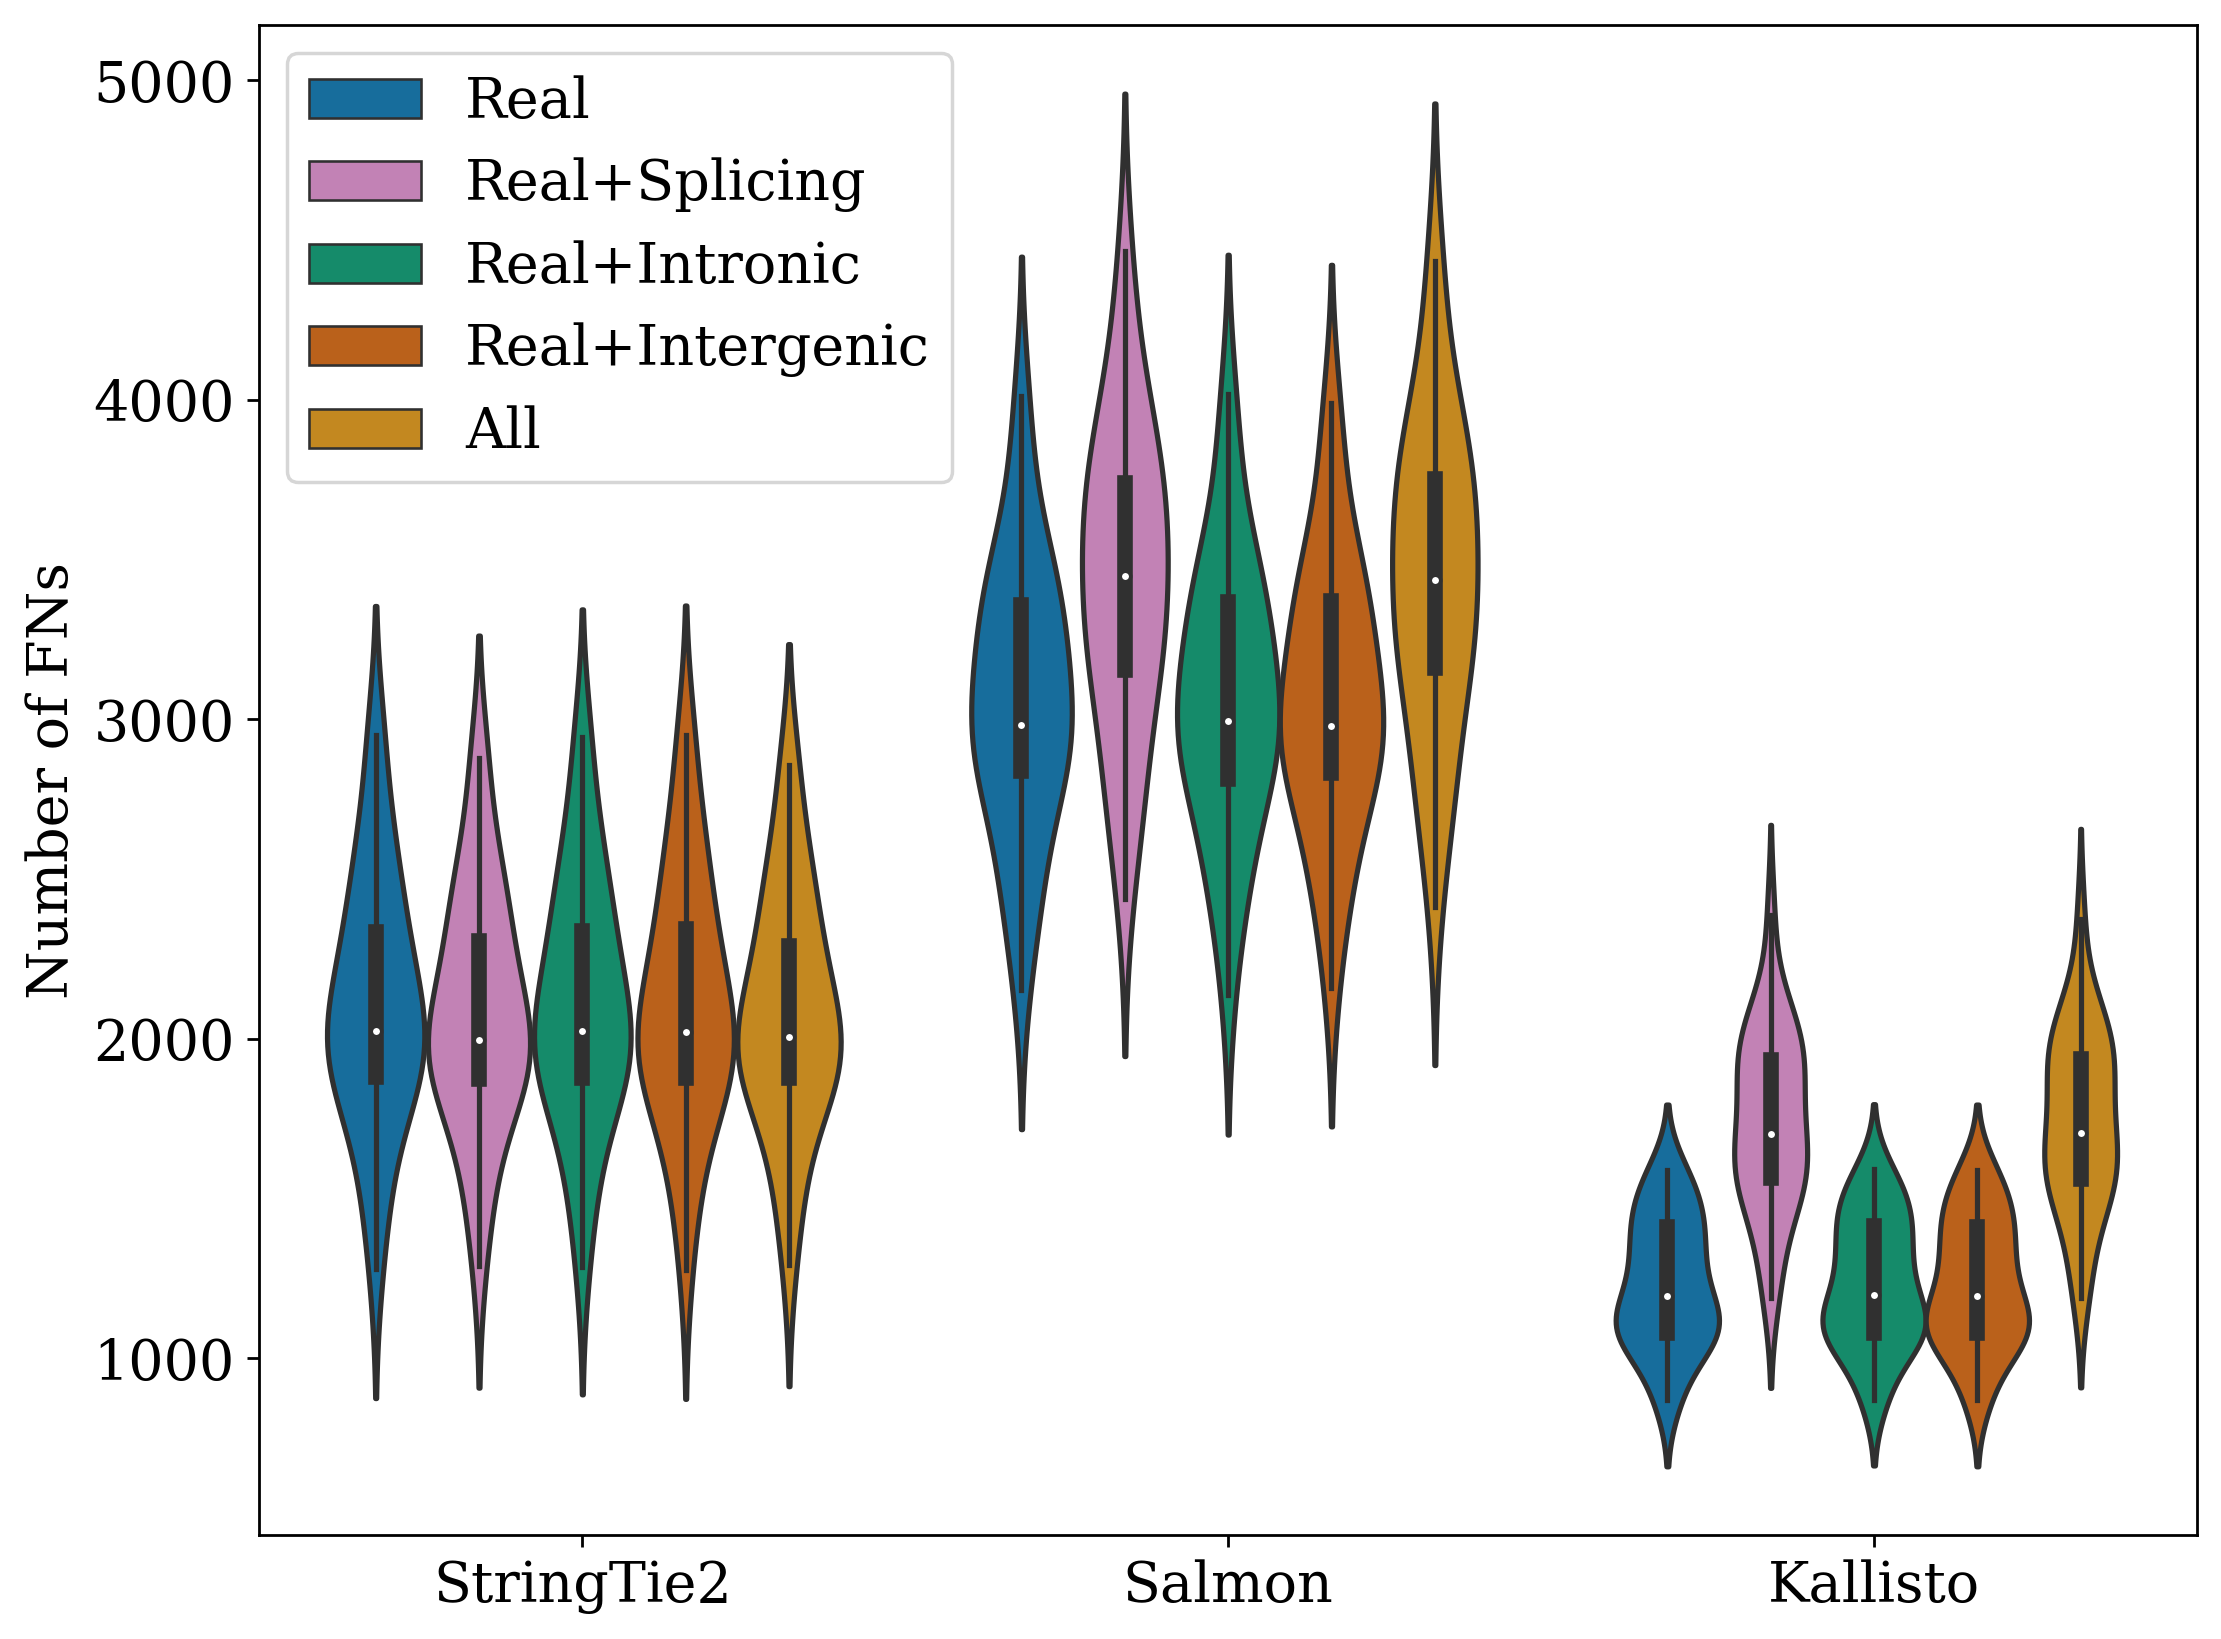

In [17]:
# plot the number of transcripts in each group
num_txs_strg_real = []
num_txs_slmn_real = []
num_txs_klst_real = []

num_txs_strg_splicing = []
num_txs_slmn_splicing = []
num_txs_klst_splicing = []

num_txs_strg_intronic = []
num_txs_slmn_intronic = []
num_txs_klst_intronic = []

num_txs_strg_intergenic = []
num_txs_slmn_intergenic = []
num_txs_klst_intergenic = []

num_txs_strg_all = []
num_txs_slmn_all = []
num_txs_klst_all = []

for i in range(len(sim_undetected_no_real)):
    num_txs_strg_real.append(len(sim_undetected_no_real[i][0]))
    num_txs_slmn_real.append(len(sim_undetected_no_real[i][1]))
    num_txs_klst_real.append(len(sim_undetected_no_real[i][2]))
    
    num_txs_strg_splicing.append(len(sim_undetected_no_splicing[i][0]))
    num_txs_slmn_splicing.append(len(sim_undetected_no_splicing[i][1]))
    num_txs_klst_splicing.append(len(sim_undetected_no_splicing[i][2]))
    
    num_txs_strg_intronic.append(len(sim_undetected_no_intronic[i][0]))
    num_txs_slmn_intronic.append(len(sim_undetected_no_intronic[i][1]))
    num_txs_klst_intronic.append(len(sim_undetected_no_intronic[i][2]))
    
    num_txs_strg_intergenic.append(len(sim_undetected_no_intergenic[i][0]))
    num_txs_slmn_intergenic.append(len(sim_undetected_no_intergenic[i][1]))
    num_txs_klst_intergenic.append(len(sim_undetected_no_intergenic[i][2]))
    
    num_txs_strg_all.append(len(sim_undetected_no_all[i][0]))
    num_txs_slmn_all.append(len(sim_undetected_no_all[i][1]))
    num_txs_klst_all.append(len(sim_undetected_no_all[i][2]))
    
tmp = pd.DataFrame(num_txs_strg_real,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df = tmp.copy(deep=True)
tmp = pd.DataFrame(num_txs_strg_splicing,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intronic,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intergenic,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_all,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_slmn_real,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_splicing,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intronic,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intergenic,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_all,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_klst_real,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_splicing,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intronic,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intergenic,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_all,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

df.reset_index(drop=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.violinplot(x="method",y="num_txs",hue="type",data=df,palette=custom_palette)
# ax.set_title("Number of unidentified simulated transcripts")
ax.set_xlabel("")
ax.set_ylabel("Number of FNs")
legend = plt.legend(loc="upper left")
fig.savefig(fig_dir+"tx_num_fn_all.png", format='png')
plt.show()

In [18]:
avg_strg_real = round(df[(df["method"]=="StringTie2")&(df["type"]=="Real")]["num_txs"].mean())
avg_slmn_real = round(df[(df["method"]=="Salmon")&(df["type"]=="Real")]["num_txs"].mean())
avg_klst_real = round(df[(df["method"]=="Kallisto")&(df["type"]=="Real")]["num_txs"].mean())

sd_strg_real = round(df[(df["method"]=="StringTie2")&(df["type"]=="Real")]["num_txs"].std())
sd_slmn_real = round(df[(df["method"]=="Salmon")&(df["type"]=="Real")]["num_txs"].std())
sd_klst_real = round(df[(df["method"]=="Kallisto")&(df["type"]=="Real")]["num_txs"].std())

for tp in set(df["type"]):
    if not tp=="Real":
        print("\n==== "+tp+" ====\n")
        avg_strg_tp = round(df[(df["method"]=="StringTie2")&(df["type"]==tp)]["num_txs"].mean())
        avg_slmn_tp = round(df[(df["method"]=="Salmon")&(df["type"]==tp)]["num_txs"].mean())
        avg_klst_tp = round(df[(df["method"]=="Kallisto")&(df["type"]==tp)]["num_txs"].mean())
        
        sd_strg_tp = round(df[(df["method"]=="StringTie2")&(df["type"]==tp)]["num_txs"].std())
        sd_slmn_tp = round(df[(df["method"]=="Salmon")&(df["type"]==tp)]["num_txs"].std())
        sd_klst_tp = round(df[(df["method"]=="Kallisto")&(df["type"]==tp)]["num_txs"].std())
        
        ch_strg = round(((avg_strg_tp-avg_strg_real)/avg_strg_real)*100,2)
        ch_slmn = round(((avg_slmn_tp-avg_slmn_real)/avg_slmn_real)*100,2)
        ch_klst = round(((avg_klst_tp-avg_klst_real)/avg_klst_real)*100,2)
        
        print("StringTie2: %change: "+str(ch_strg)+" : real: "+str(avg_strg_real)+" ; "+str(sd_strg_real)+" : new: "+str(avg_strg_tp)+" ; "+str(sd_strg_tp))
        print("Salmon: %change: "+str(ch_slmn)+" : real: "+str(avg_slmn_real)+" ; "+str(sd_slmn_real)+" : new: "+str(avg_slmn_tp)+" ; "+str(sd_slmn_tp))
        print("Kallisto: %change: "+str(ch_klst)+" : real: "+str(avg_klst_real)+" ; "+str(sd_klst_real)+" : new: "+str(avg_klst_tp)+" ; "+str(sd_klst_tp))


==== Real+Intronic ====

StringTie2: %change: 0.14 : real: 2109 ; 397 : new: 2112 ; 394
Salmon: %change: 0.13 : real: 3061 ; 431 : new: 3065 ; 431
Kallisto: %change: 0.08 : real: 1233 ; 204 : new: 1234 ; 202

==== Real+Splicing ====

StringTie2: %change: -1.09 : real: 2109 ; 397 : new: 2086 ; 377
Salmon: %change: 12.35 : real: 3061 ; 431 : new: 3439 ; 487
Kallisto: %change: 41.12 : real: 1233 ; 204 : new: 1740 ; 278

==== Real+Intergenic ====

StringTie2: %change: 0.09 : real: 2109 ; 397 : new: 2111 ; 399
Salmon: %change: 0.07 : real: 3061 ; 431 : new: 3063 ; 427
Kallisto: %change: 0.0 : real: 1233 ; 204 : new: 1233 ; 203

==== All ====

StringTie2: %change: -1.14 : real: 2109 ; 397 : new: 2085 ; 374
Salmon: %change: 12.35 : real: 3061 ; 431 : new: 3439 ; 488
Kallisto: %change: 41.2 : real: 1233 ; 204 : new: 1741 ; 277


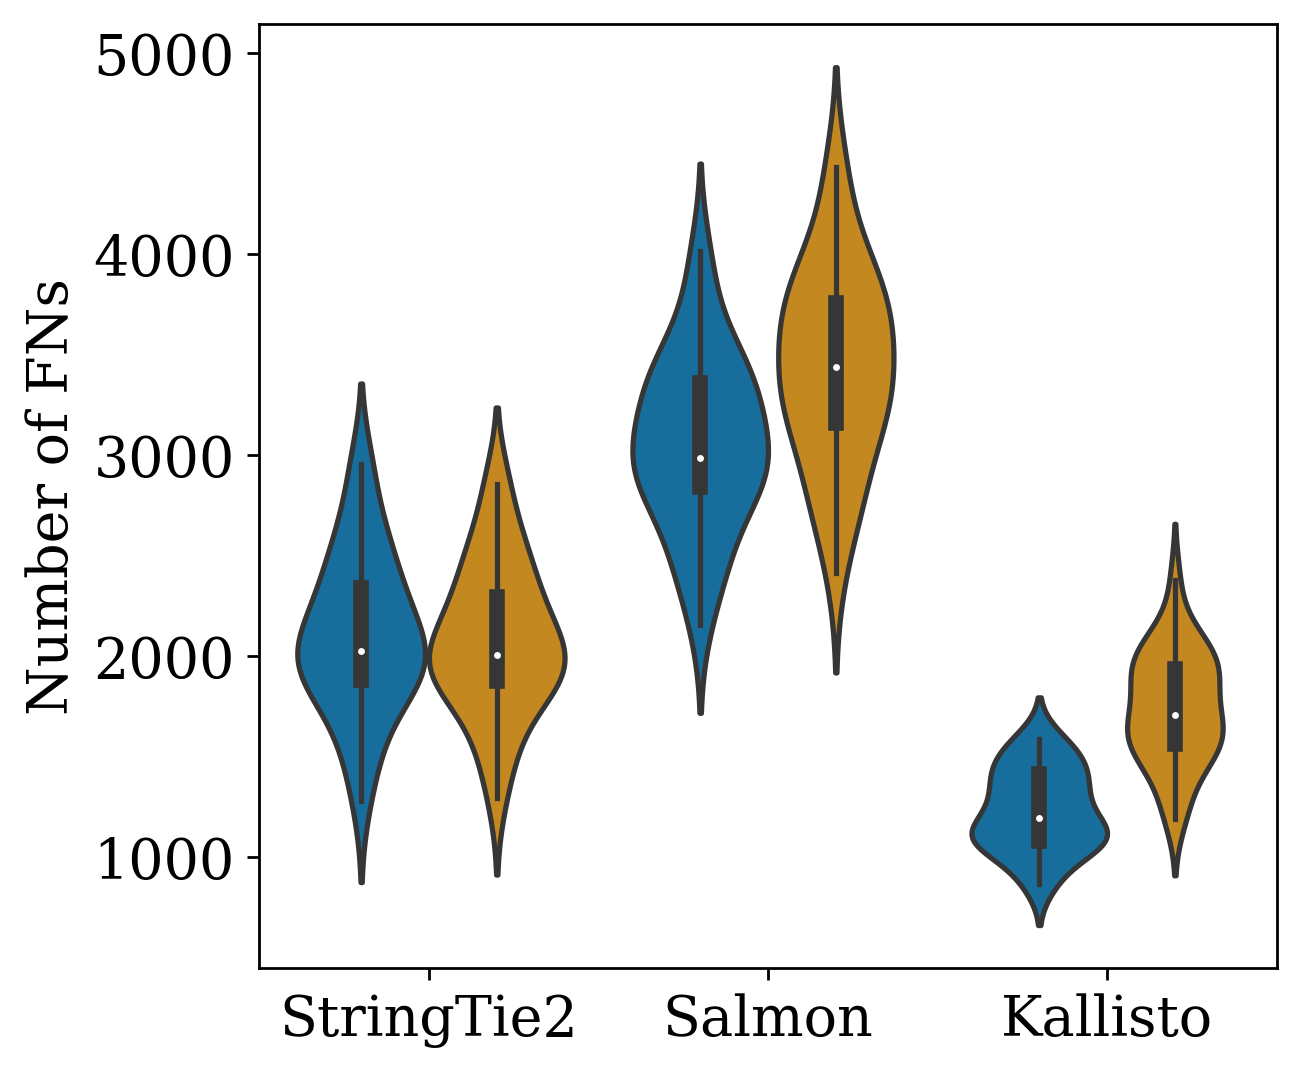

In [19]:
sub_df = df[df["type"].isin(["Real","All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(5.25,5),dpi=250)
ax = sns.violinplot(x="method",y="num_txs",hue="type",data=sub_df,palette="colorblind")
# ax.set_title("False Negative Rate in the Absence and \n Presence of Noisy Transcription")
ax.set_xlabel("")
ax.set_ylabel("Number of FNs")
# legend = ax.legend()
ax.legend().remove()
fig.savefig(fig_dir+"tx_num_fn_small.eps", format='eps')
plt.show()

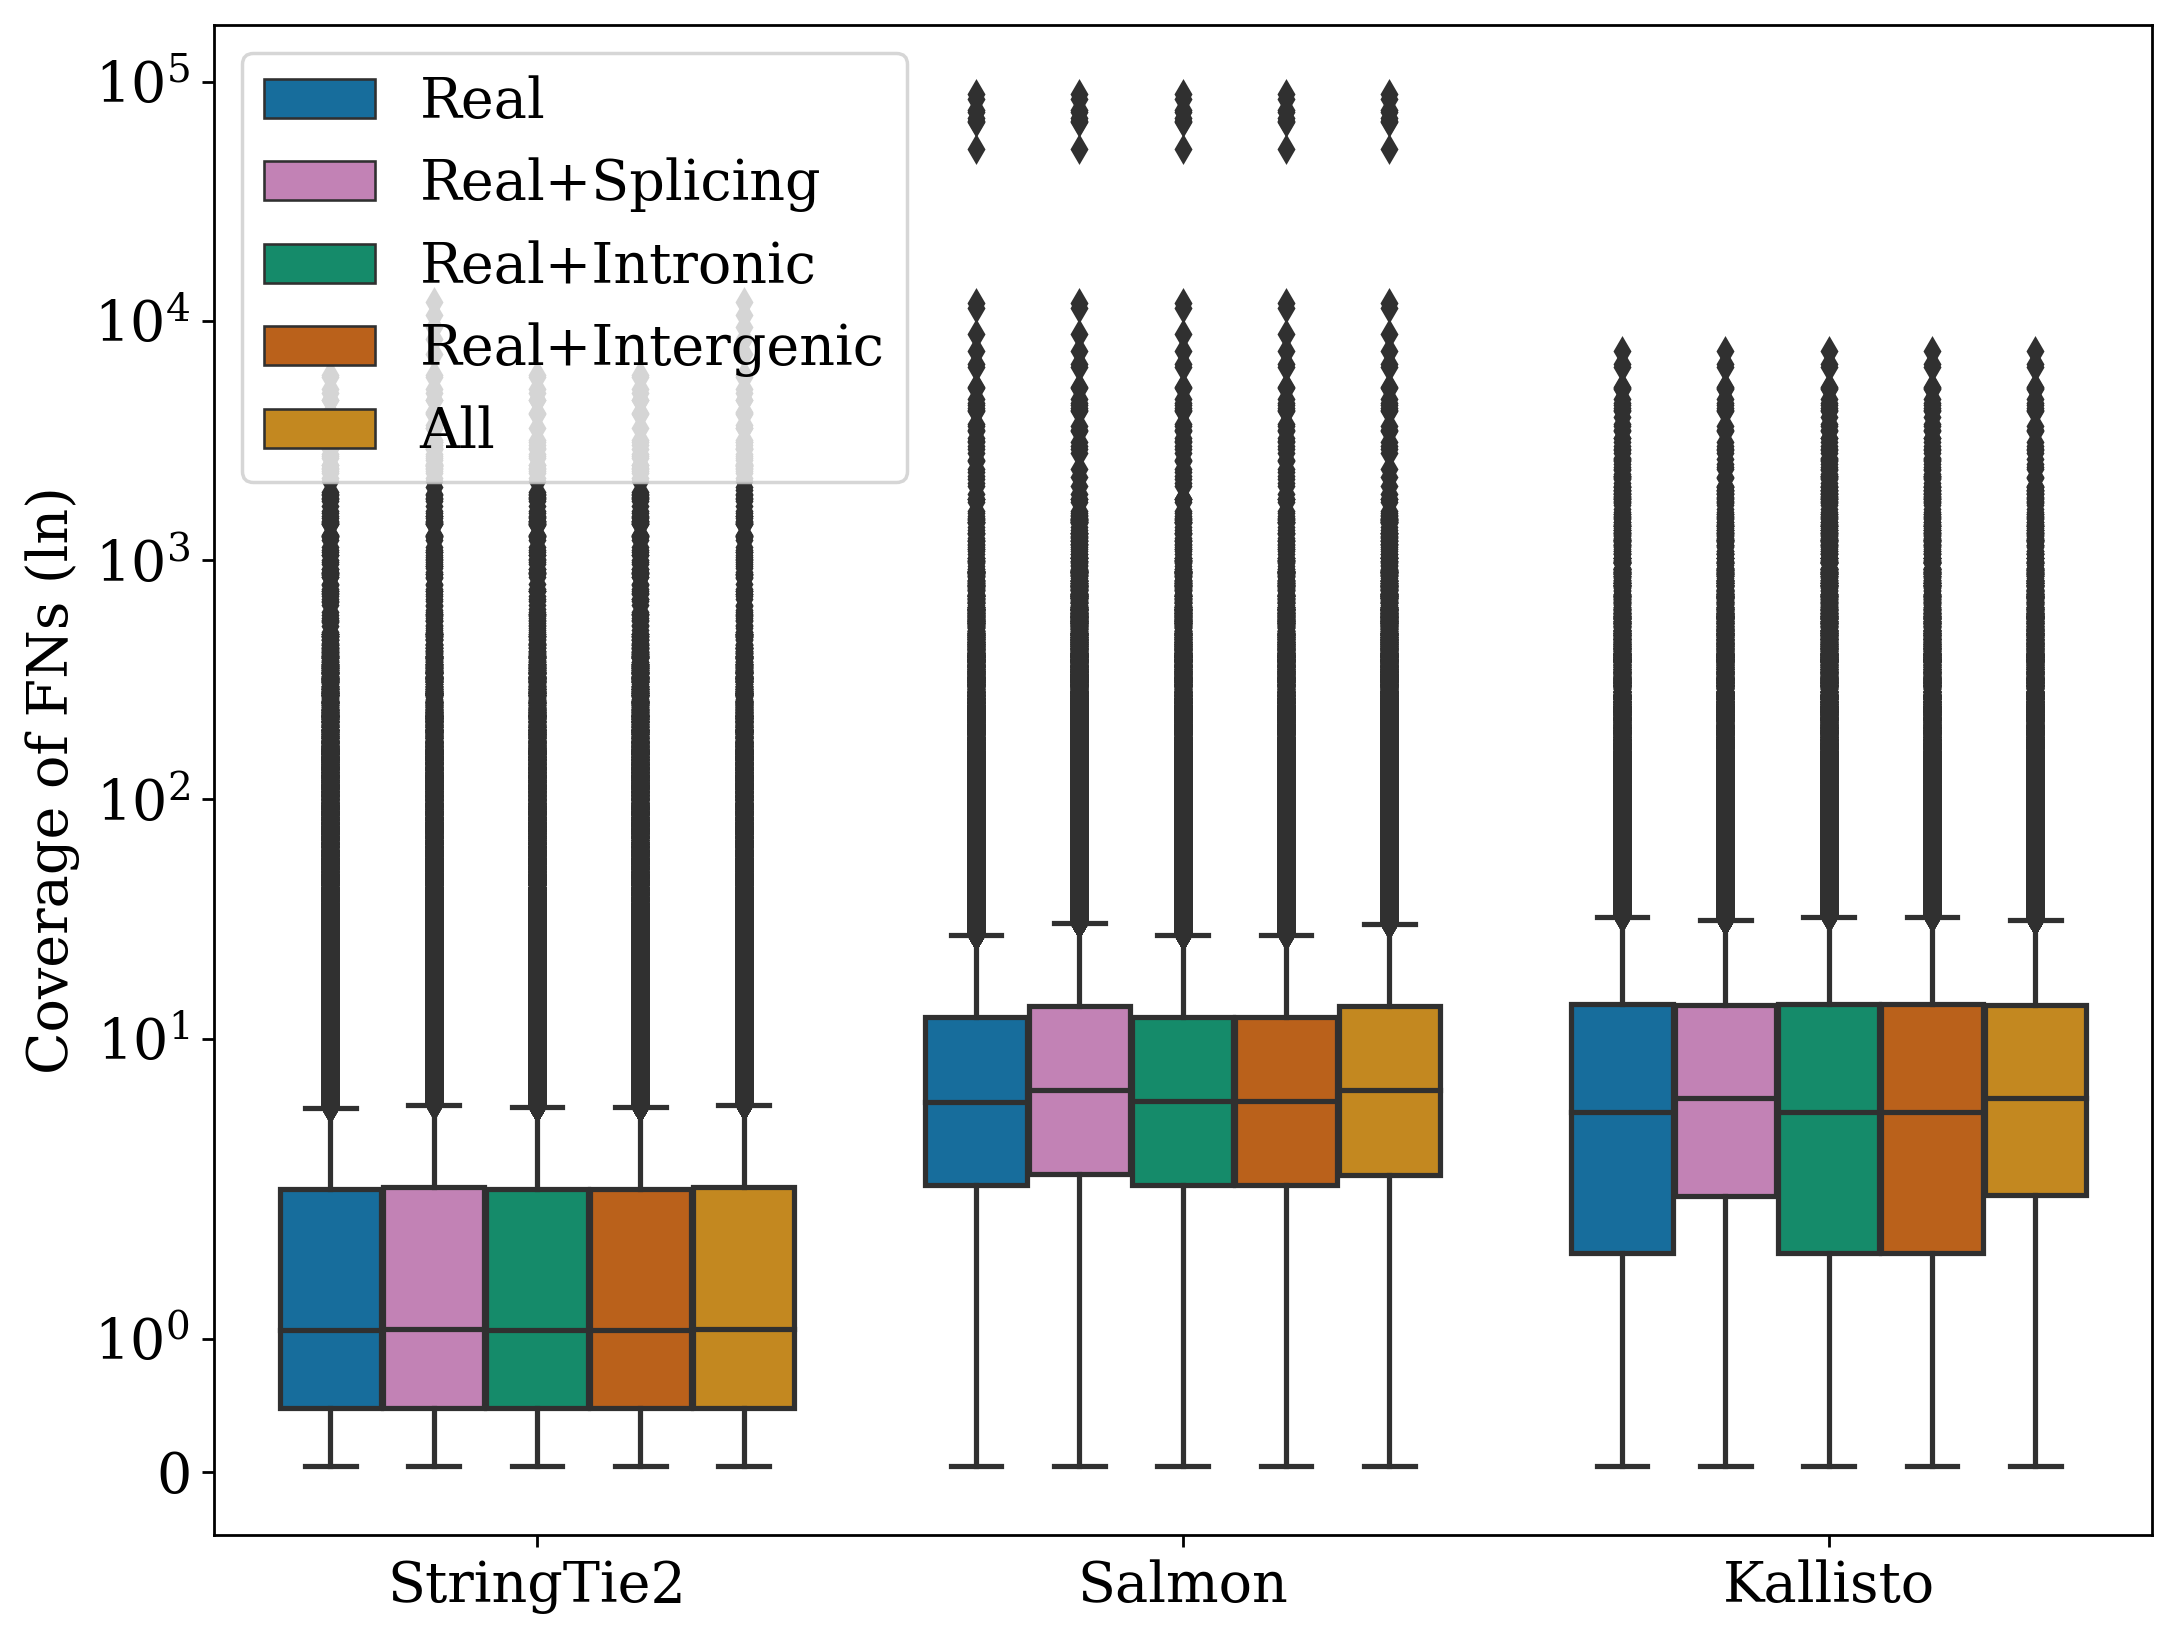

In [20]:
# plot expression values in each group
cov_strg_real = []
cov_slmn_real = []
cov_klst_real = []

cov_strg_splicing = []
cov_slmn_splicing = []
cov_klst_splicing = []

cov_strg_intronic = []
cov_slmn_intronic = []
cov_klst_intronic = []

cov_strg_intergenic = []
cov_slmn_intergenic = []
cov_klst_intergenic = []

cov_strg_all = []
cov_slmn_all = []
cov_klst_all = []

for i in range(len(sim_undetected_no_real)):
    cov_strg_real.extend(sim_undetected_no_real[i][0]["sim_cov"].tolist())
    cov_slmn_real.extend(sim_undetected_no_real[i][1]["sim_cov"].tolist())
    cov_klst_real.extend(sim_undetected_no_real[i][2]["sim_cov"].tolist())
    
    cov_strg_splicing.extend(sim_undetected_no_splicing[i][0]["sim_cov"].tolist())
    cov_slmn_splicing.extend(sim_undetected_no_splicing[i][1]["sim_cov"].tolist())
    cov_klst_splicing.extend(sim_undetected_no_splicing[i][2]["sim_cov"].tolist())
    
    cov_strg_intronic.extend(sim_undetected_no_intronic[i][0]["sim_cov"].tolist())
    cov_slmn_intronic.extend(sim_undetected_no_intronic[i][1]["sim_cov"].tolist())
    cov_klst_intronic.extend(sim_undetected_no_intronic[i][2]["sim_cov"].tolist())
    
    cov_strg_intergenic.extend(sim_undetected_no_intergenic[i][0]["sim_cov"].tolist())
    cov_slmn_intergenic.extend(sim_undetected_no_intergenic[i][1]["sim_cov"].tolist())
    cov_klst_intergenic.extend(sim_undetected_no_intergenic[i][2]["sim_cov"].tolist())
    
    cov_strg_all.extend(sim_undetected_no_all[i][0]["sim_cov"].tolist())
    cov_slmn_all.extend(sim_undetected_no_all[i][1]["sim_cov"].tolist())
    cov_klst_all.extend(sim_undetected_no_all[i][2]["sim_cov"].tolist())
    
tmp = pd.DataFrame(cov_strg_real,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df_cov = tmp.copy(deep=True)
tmp = pd.DataFrame(cov_strg_splicing,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_strg_intronic,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_strg_intergenic,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_strg_all,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df_cov = pd.concat([df_cov,tmp],axis=0)

tmp = pd.DataFrame(cov_slmn_real,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_slmn_splicing,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_slmn_intronic,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_slmn_intergenic,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_slmn_all,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df_cov = pd.concat([df_cov,tmp],axis=0)

tmp = pd.DataFrame(cov_klst_real,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_klst_splicing,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_klst_intronic,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_klst_intergenic,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_klst_all,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df_cov = pd.concat([df_cov,tmp],axis=0)

df_cov.reset_index(drop=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.boxplot(x="method",y="cov",hue="type",data=df_cov,palette=custom_palette)
ax.set_yscale("symlog")
# ax.set_title("Simulated coverage of unidentified transcripts")
ax.set_xlabel("")
ax.set_ylabel("Coverage of FNs (ln)")
legend = plt.legend(loc="upper left")
fig.savefig(fig_dir+"tx_exp_fn_all_outliers_cov.png", format='png')
plt.show()

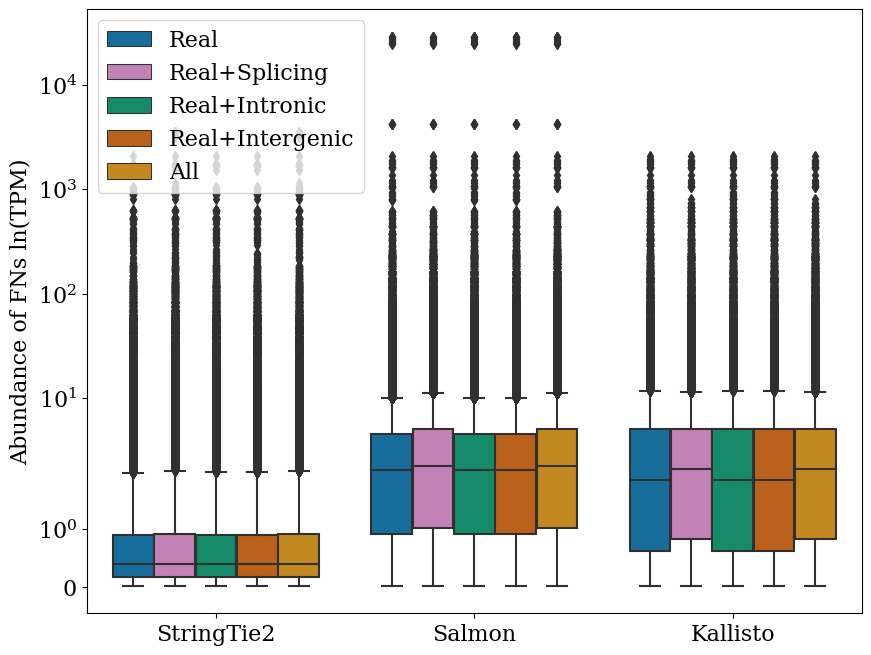

In [21]:
# plot expression values in each group
tpm_strg_real = []
tpm_slmn_real = []
tpm_klst_real = []

tpm_strg_splicing = []
tpm_slmn_splicing = []
tpm_klst_splicing = []

tpm_strg_intronic = []
tpm_slmn_intronic = []
tpm_klst_intronic = []

tpm_strg_intergenic = []
tpm_slmn_intergenic = []
tpm_klst_intergenic = []

tpm_strg_all = []
tpm_slmn_all = []
tpm_klst_all = []

for i in range(len(sim_undetected_no_real)):
    tpm_strg_real.extend(sim_undetected_no_real[i][0]["sim_tpm"].tolist())
    tpm_slmn_real.extend(sim_undetected_no_real[i][1]["sim_tpm"].tolist())
    tpm_klst_real.extend(sim_undetected_no_real[i][2]["sim_tpm"].tolist())
    
    tpm_strg_splicing.extend(sim_undetected_no_splicing[i][0]["sim_tpm"].tolist())
    tpm_slmn_splicing.extend(sim_undetected_no_splicing[i][1]["sim_tpm"].tolist())
    tpm_klst_splicing.extend(sim_undetected_no_splicing[i][2]["sim_tpm"].tolist())
    
    tpm_strg_intronic.extend(sim_undetected_no_intronic[i][0]["sim_tpm"].tolist())
    tpm_slmn_intronic.extend(sim_undetected_no_intronic[i][1]["sim_tpm"].tolist())
    tpm_klst_intronic.extend(sim_undetected_no_intronic[i][2]["sim_tpm"].tolist())
    
    tpm_strg_intergenic.extend(sim_undetected_no_intergenic[i][0]["sim_tpm"].tolist())
    tpm_slmn_intergenic.extend(sim_undetected_no_intergenic[i][1]["sim_tpm"].tolist())
    tpm_klst_intergenic.extend(sim_undetected_no_intergenic[i][2]["sim_tpm"].tolist())
    
    tpm_strg_all.extend(sim_undetected_no_all[i][0]["sim_tpm"].tolist())
    tpm_slmn_all.extend(sim_undetected_no_all[i][1]["sim_tpm"].tolist())
    tpm_klst_all.extend(sim_undetected_no_all[i][2]["sim_tpm"].tolist())
    
tmp = pd.DataFrame(tpm_strg_real,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df_tpm = tmp.copy(deep=True)
tmp = pd.DataFrame(tpm_strg_splicing,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_strg_intronic,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_strg_intergenic,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_strg_all,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df_tpm = pd.concat([df_tpm,tmp],axis=0)

tmp = pd.DataFrame(tpm_slmn_real,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_splicing,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_intronic,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_intergenic,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_all,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df_tpm = pd.concat([df_tpm,tmp],axis=0)

tmp = pd.DataFrame(tpm_klst_real,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_splicing,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_intronic,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_intergenic,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_all,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df_tpm = pd.concat([df_tpm,tmp],axis=0)

df_tpm.reset_index(drop=True)

fig = plt.figure(figsize=(10,8),dpi=100)
ax = sns.boxplot(x="method",y="tpm",hue="type",data=df_tpm,palette=custom_palette)
ax.set_yscale("symlog")
# ax.set_title("Simulated tpmerage of unidentified transcripts")
ax.set_xlabel("")
ax.set_ylabel("Abundance of FNs ln(TPM)")
legend = plt.legend(loc="upper left")
fig.savefig(fig_dir+"tx_exp_fn_all_outliers_tpm.png", format='png')
plt.show()

In [22]:
avg_strg_real = df_tpm[(df_tpm["method"]=="StringTie2")&(df_tpm["type"]=="Real")]["tpm"].median()
avg_slmn_real = df_tpm[(df_tpm["method"]=="Salmon")&(df_tpm["type"]=="Real")]["tpm"].median()
avg_klst_real = df_tpm[(df_tpm["method"]=="Kallisto")&(df_tpm["type"]=="Real")]["tpm"].median()

for tp in set(df_tpm["type"]):
    if not tp=="Real":
        print("\n==== "+tp+" ====\n")
        avg_strg_tp = df_tpm[(df_tpm["method"]=="StringTie2")&(df_tpm["type"]==tp)]["tpm"].median()
        avg_slmn_tp = df_tpm[(df_tpm["method"]=="Salmon")&(df_tpm["type"]==tp)]["tpm"].median()
        avg_klst_tp = df_tpm[(df_tpm["method"]=="Kallisto")&(df_tpm["type"]==tp)]["tpm"].median()
        
        ch_strg = round(((avg_strg_tp-avg_strg_real)/avg_strg_real)*100,2)
        ch_slmn = round(((avg_slmn_tp-avg_slmn_real)/avg_slmn_real)*100,2)
        ch_klst = round(((avg_klst_tp-avg_klst_real)/avg_klst_real)*100,2)
        
        print("StringTie2: %change: "+str(ch_strg)+" : real: "+str(round(avg_strg_real,2))+" : new: "+str(round(avg_strg_tp,2)))
        print("Salmon: %change: "+str(ch_slmn)+" : real: "+str(round(avg_slmn_real,2))+" : new: "+str(round(avg_slmn_tp,2)))
        print("Kallisto: %change: "+str(ch_klst)+" : real: "+str(round(avg_klst_real,2))+" : new: "+str(round(avg_klst_tp,2)))


==== Real+Intronic ====

StringTie2: %change: 0.17 : real: 0.4 : new: 0.4
Salmon: %change: 0.2 : real: 2.02 : new: 2.02
Kallisto: %change: 0.05 : real: 1.84 : new: 1.84

==== Real+Splicing ====

StringTie2: %change: 0.52 : real: 0.4 : new: 0.4
Salmon: %change: 11.4 : real: 2.02 : new: 2.25
Kallisto: %change: 13.63 : real: 1.84 : new: 2.09

==== Real+Intergenic ====

StringTie2: %change: 0.13 : real: 0.4 : new: 0.4
Salmon: %change: 0.3 : real: 2.02 : new: 2.02
Kallisto: %change: -0.0 : real: 1.84 : new: 1.84

==== All ====

StringTie2: %change: 0.43 : real: 0.4 : new: 0.4
Salmon: %change: 11.34 : real: 2.02 : new: 2.25
Kallisto: %change: 13.67 : real: 1.84 : new: 2.09


In [23]:
for tp in set(df_tpm["type"]):
    print("\n==== "+tp+" ====\n")
    strg_tp = len(df_tpm[(df_tpm["method"]=="StringTie2")&(df_tpm["type"]==tp)&(df_tpm["tpm"]>1)]["tpm"])
    slmn_tp = len(df_tpm[(df_tpm["method"]=="Salmon")&(df_tpm["type"]==tp)&(df_tpm["tpm"]>1)]["tpm"])
    klst_tp = len(df_tpm[(df_tpm["method"]=="Kallisto")&(df_tpm["type"]==tp)&(df_tpm["tpm"]>1)]["tpm"])

    print("StringTie2: number FN >1 TPM: "+str(strg_tp))
    print("Salmon: number FN >1 TPM: "+str(slmn_tp))
    print("Kallisto: number FN >1 TPM: "+str(klst_tp))


==== Real+Intronic ====

StringTie2: number FN >1 TPM: 14178
Salmon: number FN >1 TPM: 66736
Kallisto: number FN >1 TPM: 24089

==== Real+Splicing ====

StringTie2: number FN >1 TPM: 14336
Salmon: number FN >1 TPM: 77695
Kallisto: number FN >1 TPM: 36828

==== Real+Intergenic ====

StringTie2: number FN >1 TPM: 14133
Salmon: number FN >1 TPM: 66739
Kallisto: number FN >1 TPM: 24065

==== Real ====

StringTie2: number FN >1 TPM: 14079
Salmon: number FN >1 TPM: 66659
Kallisto: number FN >1 TPM: 24064

==== All ====

StringTie2: number FN >1 TPM: 14289
Salmon: number FN >1 TPM: 77644
Kallisto: number FN >1 TPM: 36871


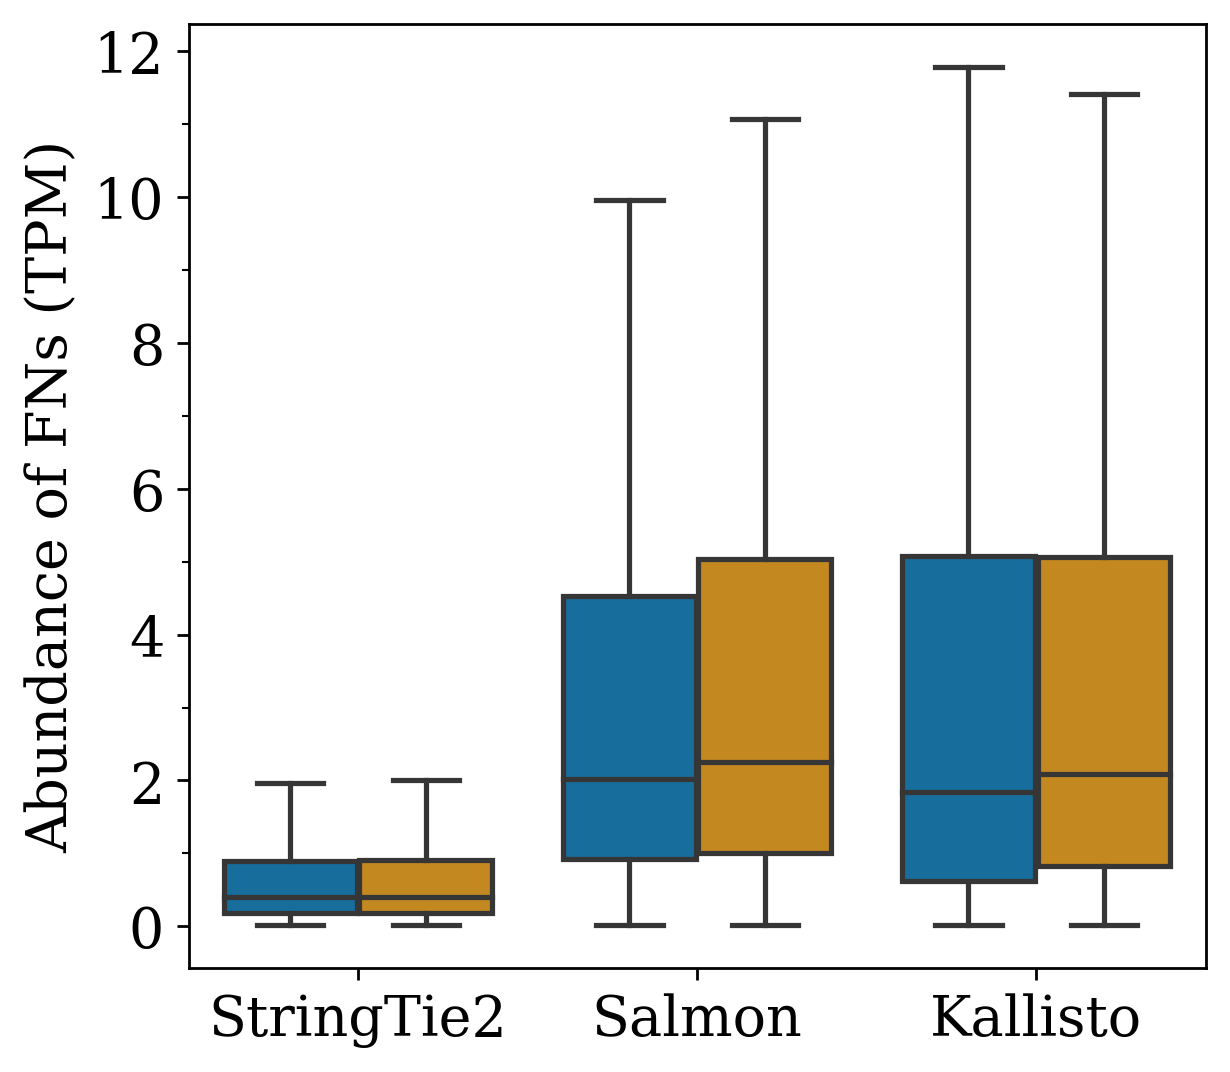

In [24]:
sub_df = df_tpm[df_tpm["type"].isin(["Real","All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(5.25,5),dpi=250)
ax = sns.boxplot(x="method",y="tpm",hue="type",data=sub_df,palette="colorblind",showfliers=False)
# ax.set_yscale("symlog")
# ax.set_title("Estimated Expression of False Positives \n in the Absence and Presence of Noise")
ax.set_xlabel("")
ax.set_ylabel("Abundance of FNs (TPM)")
legend = ax.legend()
# plt.legend(loc='upper left')
ax.legend().remove()
# ticks =  ax.get_yticks()
# print(max(ticks))
# ax.set_yticks(list(range(0,int(max(ticks)),1)))
ax.yaxis.set_minor_locator(MultipleLocator(1))
fig.savefig(fig_dir+"tx_exp_fn_small_no_outliers_tpm.eps", format='eps')
plt.show()

In [25]:
avg_strg_real = df_cov[(df_cov["method"]=="StringTie2")&(df_cov["type"]=="Real")]["cov"].median()
avg_slmn_real = df_cov[(df_cov["method"]=="Salmon")&(df_cov["type"]=="Real")]["cov"].median()
avg_klst_real = df_cov[(df_cov["method"]=="Kallisto")&(df_cov["type"]=="Real")]["cov"].median()

for tp in set(df_cov["type"]):
    if not tp=="Real":
        print("\n==== "+tp+" ====\n")
        avg_strg_tp = df_cov[(df_cov["method"]=="StringTie2")&(df_cov["type"]==tp)]["cov"].median()
        avg_slmn_tp = df_cov[(df_cov["method"]=="Salmon")&(df_cov["type"]==tp)]["cov"].median()
        avg_klst_tp = df_cov[(df_cov["method"]=="Kallisto")&(df_cov["type"]==tp)]["cov"].median()
        
        ch_strg = round(((avg_strg_tp-avg_strg_real)/avg_strg_real)*100,2)
        ch_slmn = round(((avg_slmn_tp-avg_slmn_real)/avg_slmn_real)*100,2)
        ch_klst = round(((avg_klst_tp-avg_klst_real)/avg_klst_real)*100,2)
        
        print("StringTie2: %change: "+str(ch_strg)+" : real: "+str(round(avg_strg_real,2))+" : new: "+str(round(avg_strg_tp,2)))
        print("Salmon: %change: "+str(ch_slmn)+" : real: "+str(round(avg_slmn_real,2))+" : new: "+str(round(avg_slmn_tp,2)))
        print("Kallisto: %change: "+str(ch_klst)+" : real: "+str(round(avg_klst_real,2))+" : new: "+str(round(avg_klst_tp,2)))


==== Real+Intronic ====

StringTie2: %change: 0.29 : real: 1.06 : new: 1.07
Salmon: %change: 0.18 : real: 5.46 : new: 5.47
Kallisto: %change: 0.07 : real: 4.95 : new: 4.95

==== Real+Splicing ====

StringTie2: %change: 0.78 : real: 1.06 : new: 1.07
Salmon: %change: 11.72 : real: 5.46 : new: 6.1
Kallisto: %change: 14.7 : real: 4.95 : new: 5.67

==== Real+Intergenic ====

StringTie2: %change: 0.23 : real: 1.06 : new: 1.07
Salmon: %change: 0.34 : real: 5.46 : new: 5.48
Kallisto: %change: -0.01 : real: 4.95 : new: 4.94

==== All ====

StringTie2: %change: 0.65 : real: 1.06 : new: 1.07
Salmon: %change: 11.63 : real: 5.46 : new: 6.1
Kallisto: %change: 14.74 : real: 4.95 : new: 5.67


In [26]:
for tp in set(df_cov["type"]):
    print("\n==== "+tp+" ====\n")
    strg_tp = len(df_cov[(df_cov["method"]=="StringTie2")&(df_cov["type"]==tp)&(df_cov["cov"]>1)]["cov"])
    slmn_tp = len(df_cov[(df_cov["method"]=="Salmon")&(df_cov["type"]==tp)&(df_cov["cov"]>1)]["cov"])
    klst_tp = len(df_cov[(df_cov["method"]=="Kallisto")&(df_cov["type"]==tp)&(df_cov["cov"]>1)]["cov"])

    print("StringTie2: number FP >1 reads per base: "+str(strg_tp))
    print("Salmon: number FP >1 reads per base: "+str(slmn_tp))
    print("Kallisto: number FP >1 reads per base: "+str(klst_tp))


==== Real+Intronic ====

StringTie2: number FP >1 reads per base: 32968
Salmon: number FP >1 reads per base: 82362
Kallisto: number FP >1 reads per base: 30399

==== Real+Splicing ====

StringTie2: number FP >1 reads per base: 32647
Salmon: number FP >1 reads per base: 93660
Kallisto: number FP >1 reads per base: 45264

==== Real+Intergenic ====

StringTie2: number FP >1 reads per base: 32957
Salmon: number FP >1 reads per base: 82337
Kallisto: number FP >1 reads per base: 30374

==== Real ====

StringTie2: number FP >1 reads per base: 32873
Salmon: number FP >1 reads per base: 82250
Kallisto: number FP >1 reads per base: 30373

==== All ====

StringTie2: number FP >1 reads per base: 32620
Salmon: number FP >1 reads per base: 93632
Kallisto: number FP >1 reads per base: 45307


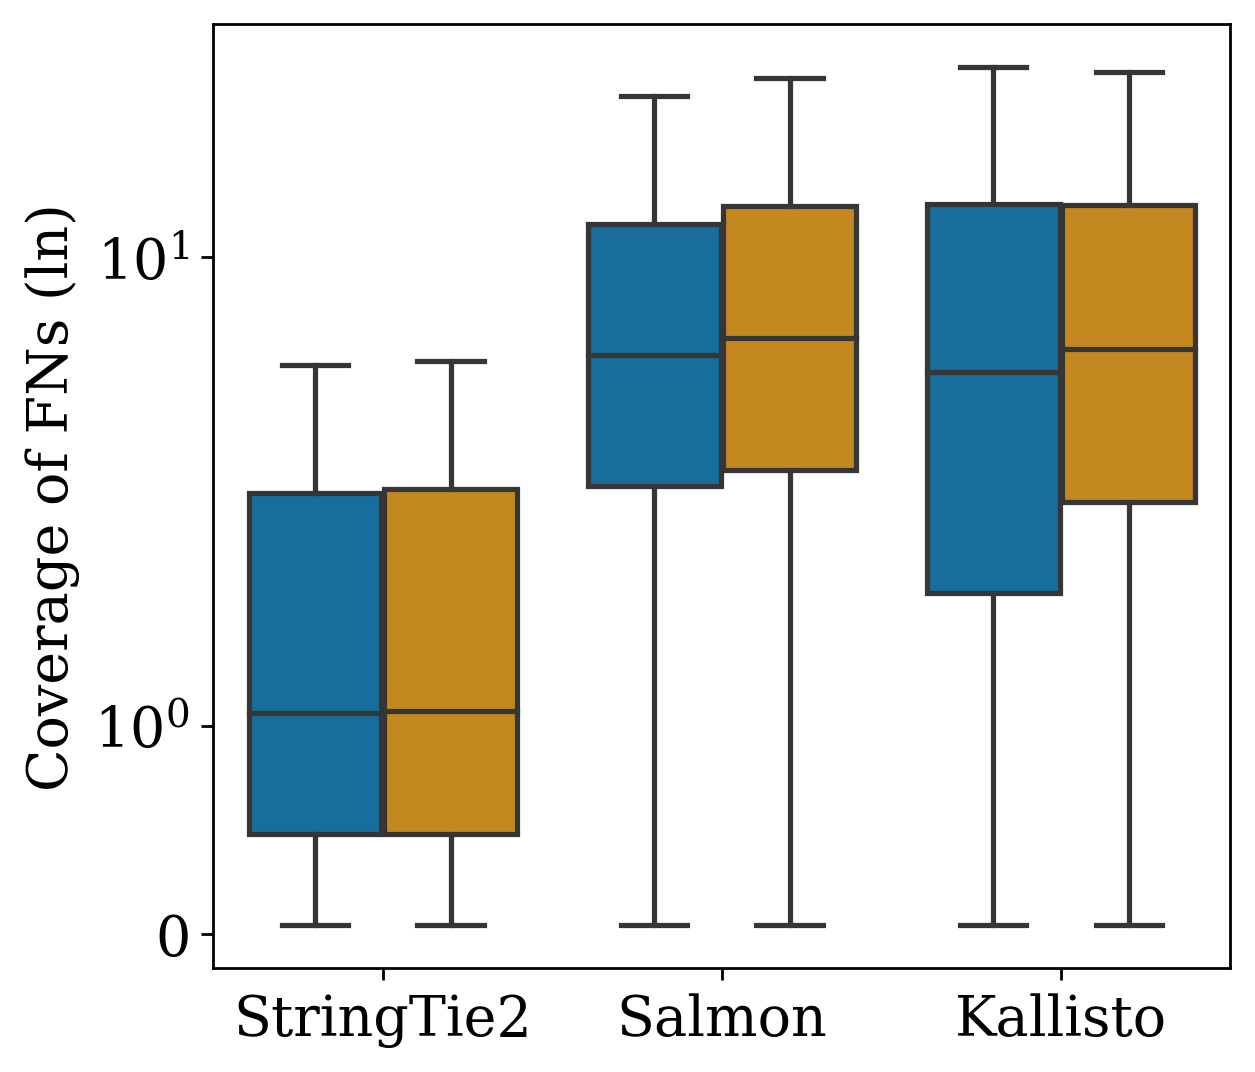

In [27]:
sub_df = df_cov[df_cov["type"].isin(["Real","All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(5.25,5),dpi=250)
ax = sns.boxplot(x="method",y="cov",hue="type",data=sub_df,palette="colorblind",showfliers=False)
ax.set_yscale("symlog")
# ax.set_title("Estimated Expression of False Positives \n in the Absence and Presence of Noise")
ax.set_xlabel("")
ax.set_ylabel("Coverage of FNs (ln)")
legend = ax.legend()
# plt.legend(loc='upper left')
ax.legend().remove()
fig.savefig(fig_dir+"tx_exp_fn_small_no_outliers_cov.eps", format='eps')
plt.show()

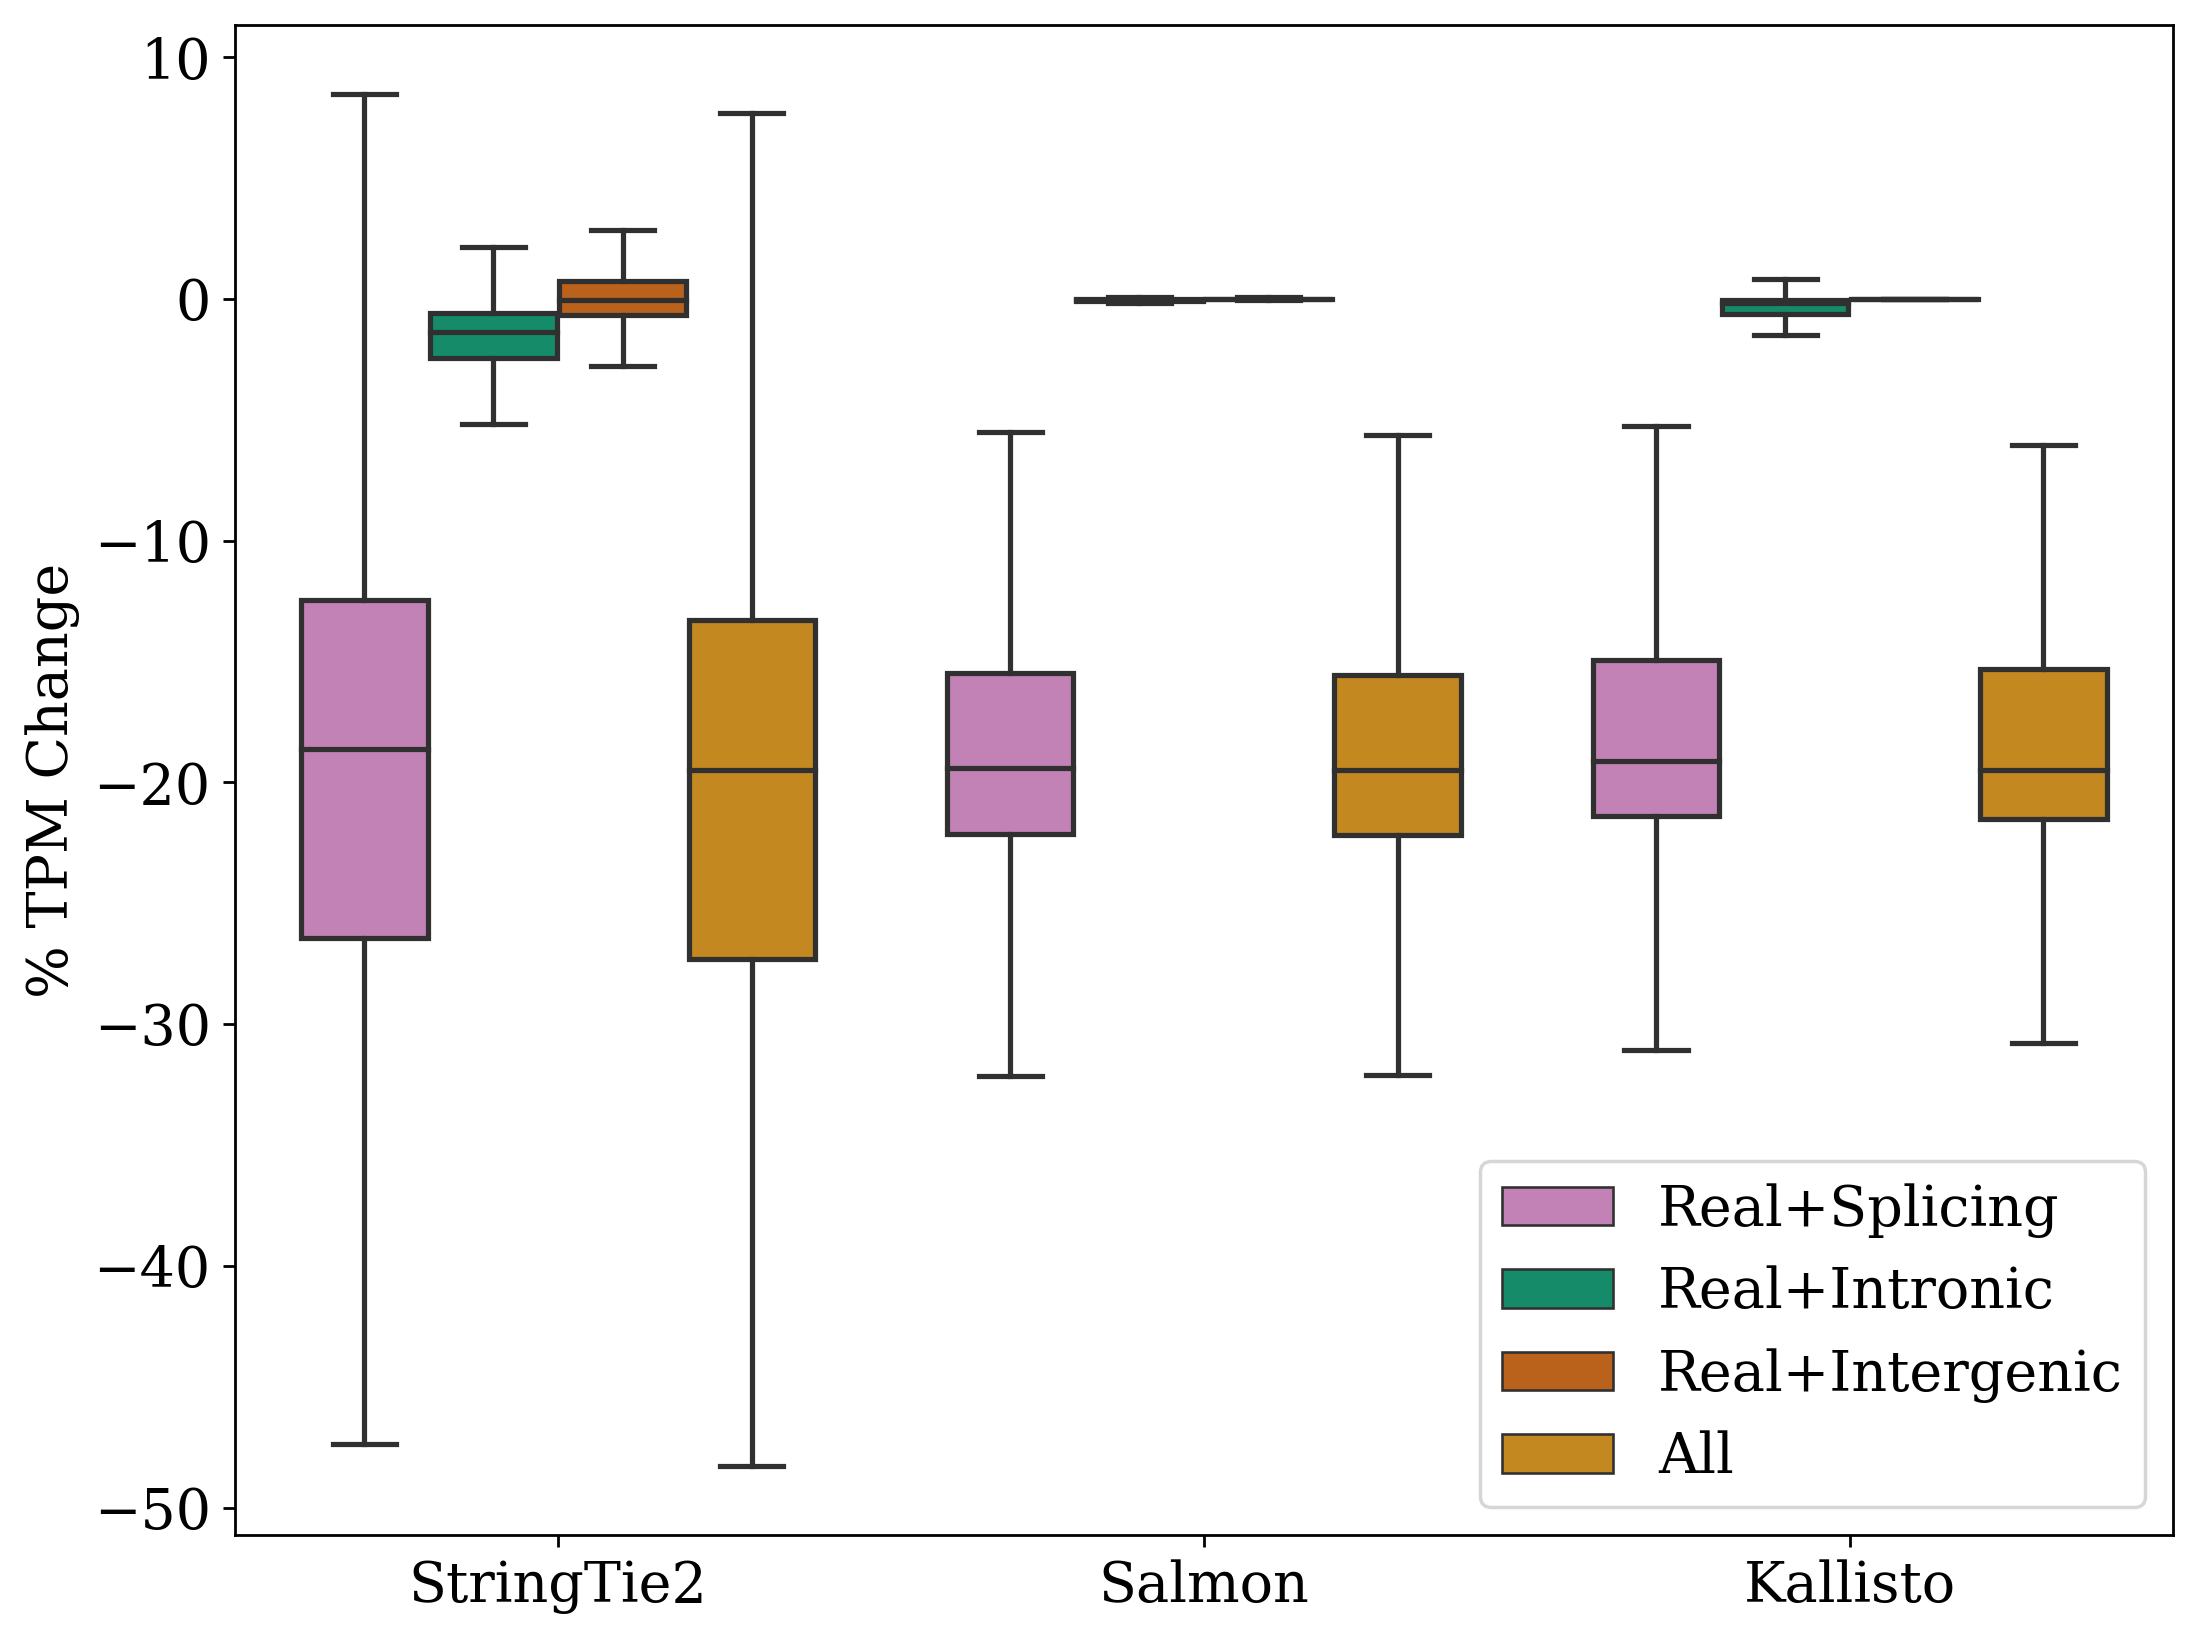

In [28]:
fold_strg_splicing = []
fold_slmn_splicing = []
fold_klst_splicing = []

fold_strg_intronic = []
fold_slmn_intronic = []
fold_klst_intronic = []

fold_strg_intergenic = []
fold_slmn_intergenic = []
fold_klst_intergenic = []

fold_strg_all = []
fold_slmn_all = []
fold_klst_all = []

for i in range(len(detected_fold_splicing)):
    fold_strg_splicing.extend(detected_fold_splicing[i][0]["strg_fold_splicing"].tolist())
    fold_slmn_splicing.extend(detected_fold_splicing[i][1]["slmn_fold_splicing"].tolist())
    fold_klst_splicing.extend(detected_fold_splicing[i][2]["klst_fold_splicing"].tolist())
    
    fold_strg_intronic.extend(detected_fold_intronic[i][0]["strg_fold_intronic"].tolist())
    fold_slmn_intronic.extend(detected_fold_intronic[i][1]["slmn_fold_intronic"].tolist())
    fold_klst_intronic.extend(detected_fold_intronic[i][2]["klst_fold_intronic"].tolist())
    
    fold_strg_intergenic.extend(detected_fold_intergenic[i][0]["strg_fold_intergenic"].tolist())
    fold_slmn_intergenic.extend(detected_fold_intergenic[i][1]["slmn_fold_intergenic"].tolist())
    fold_klst_intergenic.extend(detected_fold_intergenic[i][2]["klst_fold_intergenic"].tolist())
    
    fold_strg_all.extend(detected_fold_all[i][0]["strg_fold_all"].tolist())
    fold_slmn_all.extend(detected_fold_all[i][1]["slmn_fold_all"].tolist())
    fold_klst_all.extend(detected_fold_all[i][2]["klst_fold_all"].tolist())

tmp = pd.DataFrame(fold_strg_splicing,columns=["fold"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df_fold = tmp.copy(deep=True)
tmp = pd.DataFrame(fold_strg_intronic,columns=["fold"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_strg_intergenic,columns=["fold"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_strg_all,columns=["fold"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df_fold = pd.concat([df_fold,tmp],axis=0)

tmp = pd.DataFrame(fold_slmn_splicing,columns=["fold"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_slmn_intronic,columns=["fold"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_slmn_intergenic,columns=["fold"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_slmn_all,columns=["fold"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df_fold = pd.concat([df_fold,tmp],axis=0)

tmp = pd.DataFrame(fold_klst_splicing,columns=["fold"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_klst_intronic,columns=["fold"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_klst_intergenic,columns=["fold"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_klst_all,columns=["fold"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df_fold = pd.concat([df_fold,tmp],axis=0)

df_fold.reset_index(drop=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.boxplot(x="method",y="fold",hue="type",data=df_fold,palette=custom_palette[1:],showfliers=False)
# ax.set_yscale("symlog")
# ax.set_title("Percent change in expression estimates in the presence of noise")
ax.set_xlabel("")
ax.set_ylabel("% TPM Change")
legend = plt.legend(loc="lower right")
fig.savefig(fig_dir+"tx_fold_all_no_outliers.png", format='png')
plt.show()

In [29]:
for tp in set(df_fold["type"]):
    print("\n==== "+tp+" ====\n")
    strg_tp = df_fold[(df_fold["method"]=="StringTie2")&(df_fold["type"]==tp)]["fold"].median()
    slmn_tp = df_fold[(df_fold["method"]=="Salmon")&(df_fold["type"]==tp)]["fold"].median()
    klst_tp = df_fold[(df_fold["method"]=="Kallisto")&(df_fold["type"]==tp)]["fold"].median()

    print("StringTie2: median: "+str(strg_tp))
    print("Salmon: median: "+str(slmn_tp))
    print("Kallisto: median: "+str(klst_tp))


==== Real+Splicing ====

StringTie2: median: -18.621622138050952
Salmon: median: -19.41524879866014
Kallisto: median: -19.098152721854184

==== Real+Intergenic ====

StringTie2: median: -0.0321938067164372
Salmon: median: 0.0008365367596913729
Kallisto: median: -0.0005886480472655782

==== All ====

StringTie2: median: -19.496647549860167
Salmon: median: -19.477574022601594
Kallisto: median: -19.49982885112314

==== Real+Intronic ====

StringTie2: median: -1.3751634796597367
Salmon: median: -0.05052791998658778
Kallisto: median: -0.1759645010745634


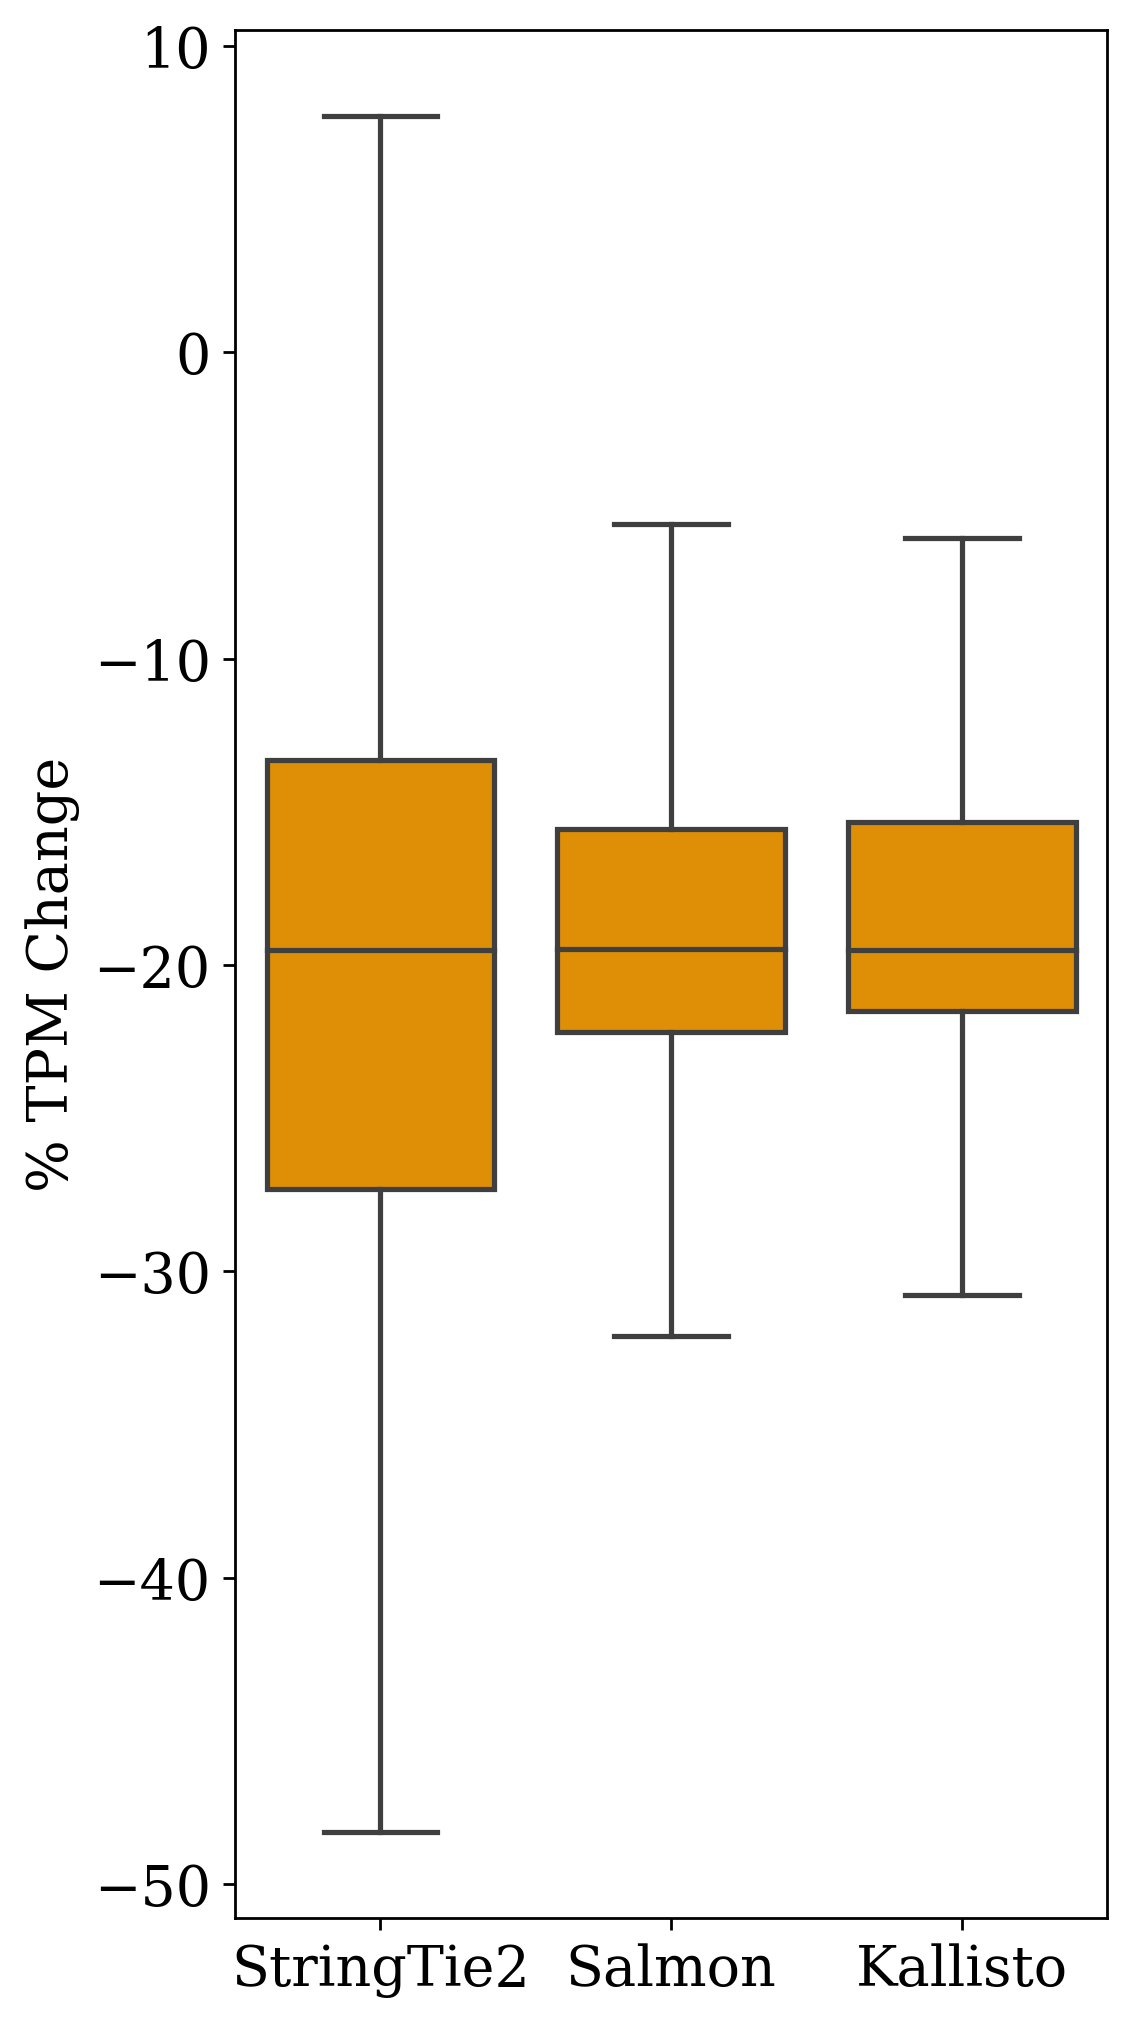

In [30]:
sub_df = df_fold[df_fold["type"].isin(["All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(4.5,10),dpi=250)
ax = sns.boxplot(x="method",y="fold",hue="type",data=sub_df,showfliers=False)
for i in range(len(ax.artists)):
    ax.artists[i].set_facecolor(sns.color_palette("colorblind").as_hex()[1])
# sns.color_palette("colorblind").as_hex()[1]
ax.set_xlabel("")
ax.set_ylabel("% TPM Change")
ax.legend().remove()
fig.savefig(fig_dir+"tx_fold_small_no_outliers.eps",format='eps')
plt.show()

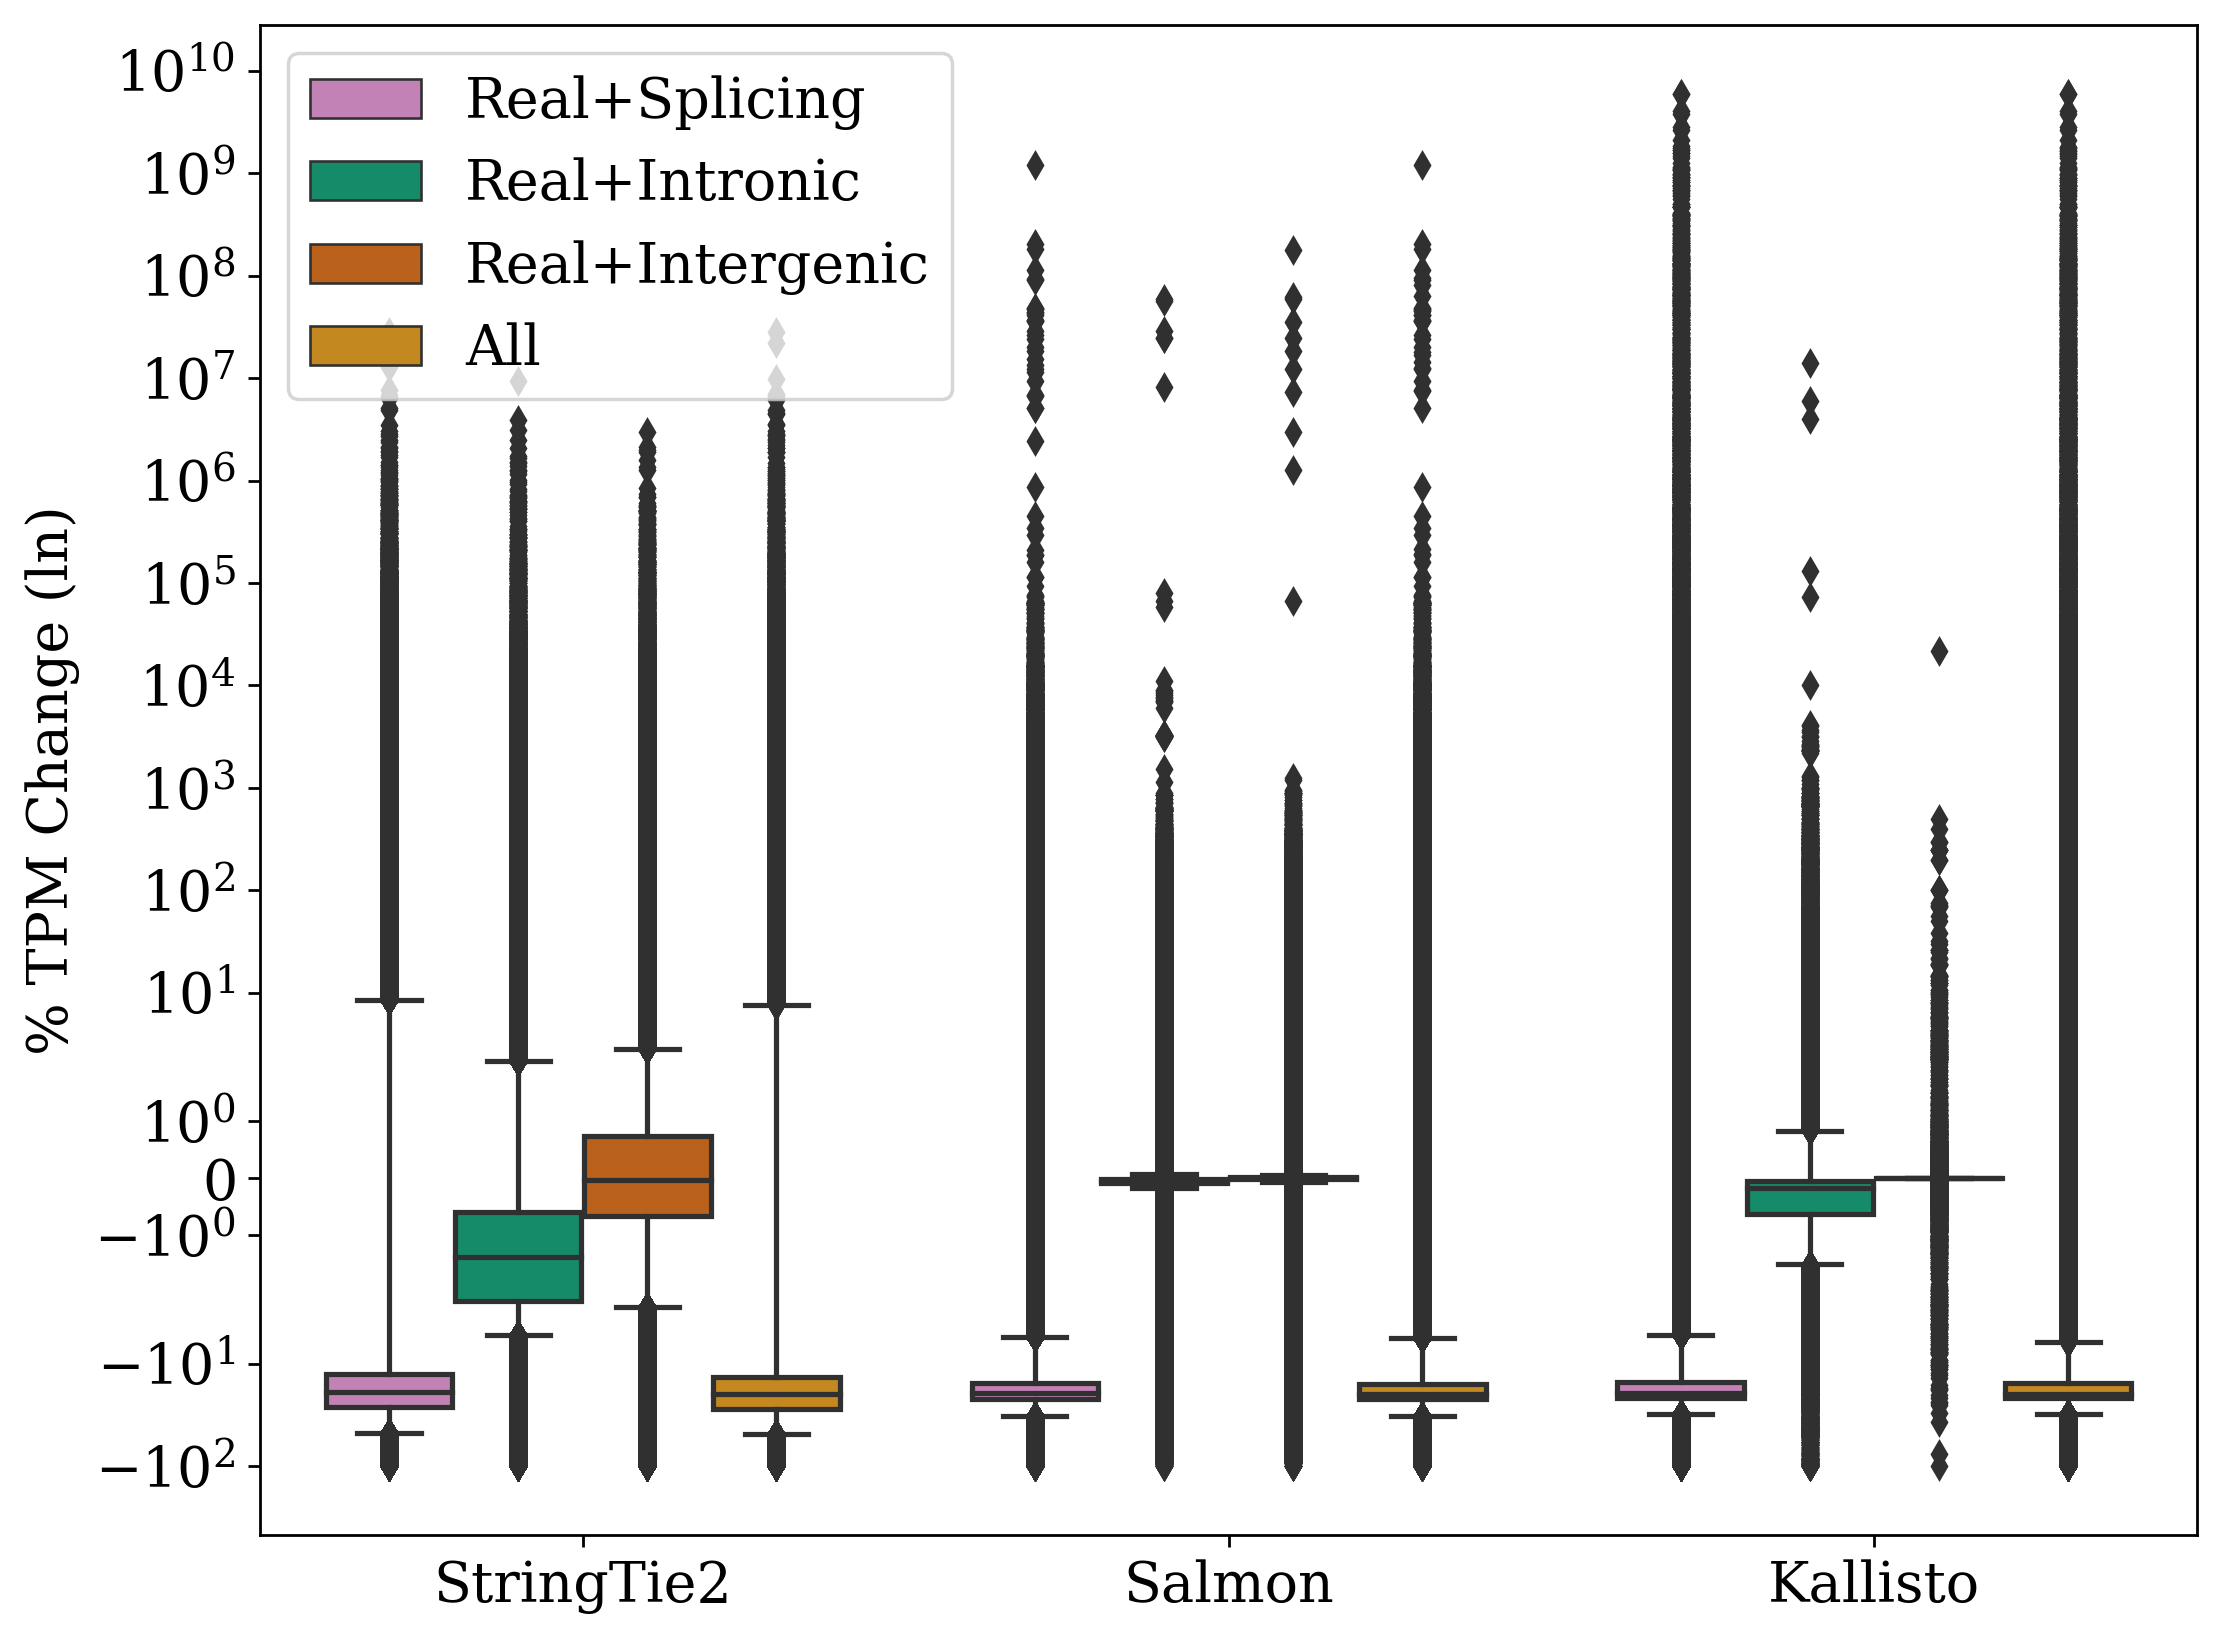

In [31]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.boxplot(x="method",y="fold",hue="type",data=df_fold,palette=custom_palette[1:])
ax.set_yscale("symlog")
# ax.set_title("Fold change in expression estimates in the presence of noise")
ax.set_xlabel("")
ax.set_ylabel("% TPM Change (ln)")
legend = plt.legend(loc="upper left")
fig.savefig(fig_dir+"tx_fold_all_outliers.png", format='png')
plt.show()

In [32]:
# same plot but fold change compared to the truth (sim_n_reads)

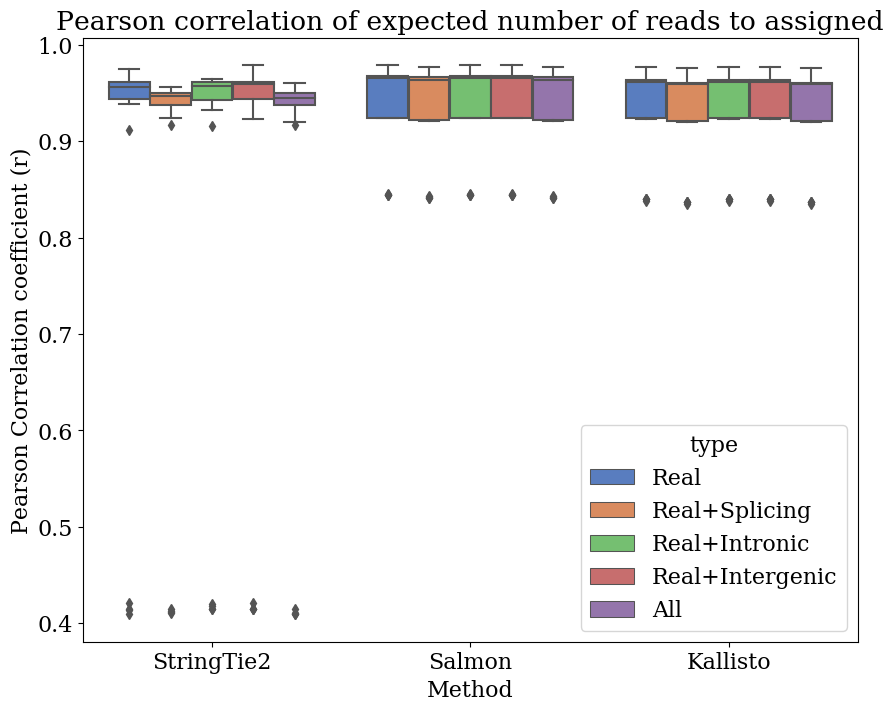

In [33]:
# plot the number of transcripts in each group
r_strg_real = []
r_slmn_real = []
r_klst_real = []

r_strg_splicing = []
r_slmn_splicing = []
r_klst_splicing = []

r_strg_intronic = []
r_slmn_intronic = []
r_klst_intronic = []

r_strg_intergenic = []
r_slmn_intergenic = []
r_klst_intergenic = []

r_strg_all = []
r_slmn_all = []
r_klst_all = []

for i in range(len(detected_r_real)):
    r_strg_real.append(detected_r_real[i][0])
    r_slmn_real.append(detected_r_real[i][1])
    r_klst_real.append(detected_r_real[i][2])
    
    r_strg_splicing.append(detected_r_splicing[i][0])
    r_slmn_splicing.append(detected_r_splicing[i][1])
    r_klst_splicing.append(detected_r_splicing[i][2])
    
    r_strg_intronic.append(detected_r_intronic[i][0])
    r_slmn_intronic.append(detected_r_intronic[i][1])
    r_klst_intronic.append(detected_r_intronic[i][2])
    
    r_strg_intergenic.append(detected_r_intergenic[i][0])
    r_slmn_intergenic.append(detected_r_intergenic[i][1])
    r_klst_intergenic.append(detected_r_intergenic[i][2])
    
    r_strg_all.append(detected_r_all[i][0])
    r_slmn_all.append(detected_r_all[i][1])
    r_klst_all.append(detected_r_all[i][2])
    
tmp = pd.DataFrame(r_strg_real,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df = tmp.copy(deep=True)
tmp = pd.DataFrame(r_strg_splicing,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_strg_intronic,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_strg_intergenic,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_strg_all,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(r_slmn_real,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_slmn_splicing,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_slmn_intronic,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_slmn_intergenic,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_slmn_all,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(r_klst_real,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_klst_splicing,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_klst_intronic,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_klst_intergenic,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_klst_all,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

df.reset_index(drop=True)

fig = plt.figure(figsize=(10,8),dpi=100)
ax = sns.boxplot(x="method",y="r",hue="type",data=df,palette="muted")
ax.set_title("Pearson correlation of expected number of reads to assigned")
ax.set_xlabel("Method")
ax.set_ylabel("Pearson Correlation coefficient (r)")
plt.show()